# Car residual value modelling (PoC)

## I. Importer les librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models import DataPreprocessor, univariate_analysis, bivariate_analysis, multivariate_analysis, scatter_3d
from src.models import create_transformer_pipeline
from src.models import CategoricalEmbedding, plot_embeddings, visualize_all_embeddings
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
import tensorflow as tf

## II. Data Preprocessing

### 1. Déclaration des chemins de data

In [4]:
# Le chemin vers les données d'annonce
annonce_path = os.path.join("..", "data", "raw_data", "autohero.csv")

# Le chemin vers les données de prix neuf
prix_neuf_path = os.path.join("..", "data", "scraping_prix_neuf", "prix_neuf_voitures_vf.csv")

### 2. Création d'une instance de Data Preprocessor

In [5]:
# Créer une instance de la classe DataPreprocessor
preprocessor = DataPreprocessor(file_path=annonce_path)

### 3. Charger les données d'annonces & les prétransformer

In [6]:
# Charger les données
preprocessor.load_data()
# Afficher la dimension du DataFrame
print(f"La dimension du DataFrame est: {preprocessor.data.shape}") 
preprocessor.data.head()

Data loaded successfully from ..\data\raw_data\autohero.csv
La dimension du DataFrame est: (2352, 20)


scraped_at             modele                     finition      prix  \
0  2025-04-09        Ford Fiesta       1.0 EcoBoost ST-Line X  13 190 €   
1  2025-04-09      Toyota ProAce  Combi Long 1.5 D-4D Dynamic  23 990 €   
2  2025-04-09  Mercedes-Benz GLA        250 e AMG Line 8G-DCT  32 490 €   
3  2025-04-09             BMW X1         sDrive18i xLine DKG7  27 890 €   
4  2025-04-09       Peugeot 3008   1.5 Blue-HDi Crossway EAT8  19 090 €   

  annee_mise_en_circulation kilometrage carburant  \
0                15.05.2020   69 301 km   Essence   
1                29.04.2021   71 887 km    Diesel   
2                23.10.2020   59 649 km   Hybride   
3                05.05.2021   37 869 km   Essence   
4                31.12.2019   58 958 km    Diesel   

                   transmission        puissance nb_ancien_proprietaire  \
0     Boite de vitesse manuelle    95 CV / 70 kW                      3   
1     Boite de vitesse manuelle   120 CV / 88 kW                      2   
2        Double embrayage / DCT  218 CV / 160 kW                      2   
3        Double embrayage / DCT  136 CV / 100 kW                      2   
4  Boite de vitesse automatique   130 CV / 96 kW                      3   

  classe_vehicule  nb_porte  nb_place couleur                      sellerie  \
0        Citadine       5.0       5.0    Gris    Tissu (Sellerie d'origine)   
1       Monospace       4.0       9.0    Gris    Tissu (Sellerie d'origine)   
2             SUV       5.0       5.0    Gris  Mi-cuir (Sellerie d'origine)   
3             SUV       5.0       5.0    Noir  Mi-cuir (Sellerie d'origine)   
4             SUV       5.0       5.0   Blanc  Mi-cuir (Sellerie d'origine)   

  classe_emission emission_CO2    crit_air usage_commerciale_anterieure  \
0          EURO 6          NaN  Crit'Air 1                          NaN   
1          EURO 6     170 g/km  Crit'Air 2                          Oui   
2          EURO 6      32 g/km  Crit'Air 1                          Oui   
3          EURO 6     148 g/km  Crit'Air 1                          Non   
4          EURO 6      98 g/km  Crit'Air 2                          Oui   

                                         url_annonce  
0  https://www.autohero.com/fr/ford-fiesta/id/516...  
1  https://www.autohero.com/fr/toyota-pro-ace/id/...  
2  https://www.autohero.com/fr/mercedes-benz-gla/...  
3  https://www.autohero.com/fr/bmw-x-1/id/490f203...  
4  https://www.autohero.com/fr/peugeot-3008/id/df...

In [7]:
# Prétransformer les données en ajoutant les nouvelles colonnes et homogénéisant les données
preprocessor.pretransform_data()
print(f"Après la pré-transformation, la nouvelle dimension est: {preprocessor.data.shape}")
preprocessor.data.head() 

Après la pré-transformation, la nouvelle dimension est: (2352, 30)


scraped_at    marque             modele                     finition  \
0  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
2  2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   
3  2025-04-09       BMW             BMW X1         SDRIVE18I XLINE DKG7   
4  2025-04-09   PEUGEOT       PEUGEOT 3008   1.5 BLUE-HDI CROSSWAY EAT8   

      prix annee_mise_en_circulation  kilometrage carburant  \
0  13190.0                15.05.2020      69301.0   Essence   
1  23990.0                29.04.2021      71887.0    Diesel   
2  32490.0                23.10.2020      59649.0   Hybride   
3  27890.0                05.05.2021      37869.0   Essence   
4  19090.0                31.12.2019      58958.0    Diesel   

                   transmission  puissance  ...  \
0     Boite de vitesse manuelle         95  ...   
1     Boite de vitesse manuelle        120  ...   
2  Boite de vitesse automatique        218  ...   
3  Boite de vitesse automatique        136  ...   
4  Boite de vitesse automatique        130  ...   

                                         url_annonce annee age_days age_years  \
0  https://www.autohero.com/fr/ford-fiesta/id/516...  2020   1790.0       4.9   
1  https://www.autohero.com/fr/toyota-pro-ace/id/...  2021   1441.0       3.9   
2  https://www.autohero.com/fr/mercedes-benz-gla/...  2020   1629.0       4.5   
3  https://www.autohero.com/fr/bmw-x-1/id/490f203...  2021   1435.0       3.9   
4  https://www.autohero.com/fr/peugeot-3008/id/df...  2019   1926.0       5.3   

  age_months km_per_year km_per_month         modele_alt  \
0       59.7     14143.1       1160.8        FORD FIESTA   
1       48.0     18432.6       1497.6      TOYOTA PROACE   
2       54.3     13255.3       1098.5  MERCEDES-BENZ GLA   
3       47.8      9710.0        792.2             BMW X1   
4       64.2     11124.2        918.3       PEUGEOT 3008   

                   finition_puissance id_annonce  
0        1.0 ECOBOOST ST-LINE X 95 CV          1  
1  COMBI LONG 1.5 D-4D DYNAMIC 120 CV          2  
2        250 E AMG LINE 8G-DCT 218 CV          3  
3         SDRIVE18I XLINE DKG7 136 CV          4  
4   1.5 BLUE-HDI CROSSWAY EAT8 130 CV          5  

[5 rows x 30 columns]

### 4. Récupération des prix neuf

In [8]:
# Récupérer le prix neuf
preprocessor.merge_new_price(prix_neuf_path)
print(f"Après la récupération du prix neuf, la nouvelle dimension est: {preprocessor.data.shape}") 
preprocessor.data.head()

Après la récupération du prix neuf, la nouvelle dimension est: (6812, 52)


scraped_at    marque             modele                     finition  \
0  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
2  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
3  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
4  2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   

      prix annee_mise_en_circulation  kilometrage carburant  \
0  13190.0                15.05.2020      69301.0   Essence   
1  13190.0                15.05.2020      69301.0   Essence   
2  23990.0                29.04.2021      71887.0    Diesel   
3  23990.0                29.04.2021      71887.0    Diesel   
4  32490.0                23.10.2020      59649.0   Hybride   

                   transmission  puissance  ... np_energie np_prix_neuf  \
0     Boite de vitesse manuelle         95  ...    Essence        21650   
1     Boite de vitesse manuelle         95  ...    Essence        21650   
2     Boite de vitesse manuelle        120  ...     Diesel        34290   
3     Boite de vitesse manuelle        120  ...     Diesel        34240   
4  Boite de vitesse automatique        218  ...    Hybride        55600   

                                   np_version_finale note_version_commune  \
0  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 3P                    5   
1  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 5P                    5   
2  TOYOTA PROACE 2 II (2) COMBI LONG 1.5 120 D-4D...                    6   
3  TOYOTA PROACE 2 II (2) PROACE COMBI LONG 1.5 1...                    6   
4            MERCEDES GLA 2 II 250 E AMG LINE 8G-DCT                    5   

  note_transmission_commune note_carburant_commun note_nb_porte_commun  \
0                         1                     1                    0   
1                         1                     1                    0   
2                         1                     1                    0   
3                         1                     1                    0   
4                         1                     1                    0   

   note_totale_commune max_note nb_match_par_annonce  
0                    7        7                    2  
1                    7        7                    2  
2                    8        8                    2  
3                    8        8                    2  
4                    7        7                    1  

[5 rows x 52 columns]

In [9]:
print(f"Nombre total d'annonces: {preprocessor.data['id_annonce'].drop_duplicates().shape[0]}")
print(f"Nombre d'annonces où le prix neuf est renseigné: {preprocessor.data[preprocessor.data['np_prix_neuf'].notnull()][['id_annonce']].drop_duplicates().shape[0]}")
print(f"Nombre d'annonces où le prix neuf n'est pas trouvé: {preprocessor.data[preprocessor.data['np_prix_neuf'].isnull()][['id_annonce']].drop_duplicates().shape[0]}")

Nombre total d'annonces: 2352
Nombre d'annonces où le prix neuf est renseigné: 2339
Nombre d'annonces où le prix neuf n'est pas trouvé: 13


In [10]:
# Annonces dont le prix neuf est manquant
df = preprocessor.data.copy()
df_miss_prix = df[df["np_prix_neuf"].isnull()]
df_miss_prix.value_counts(subset=['modele', 'modele_alt'])

modele                    modele_alt
CITROEN C4 GRAND PICASSO  C4 PICASSO    1
CITROEN C4 PICASSO        C4 PICASSO    1
KIA PRO_CEE'D             PROCEED       1
Name: count, dtype: int64

In [11]:
df_miss_prix

scraped_at   marque                    modele  \
1077  2025-04-09  CITROEN        CITROEN C4 PICASSO   
2105  2025-04-09  CITROEN  CITROEN C4 GRAND PICASSO   
2108  2025-04-09      KIA             KIA PRO_CEE'D   
2364  2025-04-09      NaN                       NaN   
2823  2025-04-09      NaN                       NaN   
3015  2025-04-09      NaN                       NaN   
4441  2025-04-09      NaN                       NaN   
5086  2025-04-09      NaN                       NaN   
5408  2025-04-09      NaN                       NaN   
5638  2025-04-09      NaN                       NaN   
5940  2025-04-09      NaN                       NaN   
6240  2025-04-09      NaN                       NaN   
6712  2025-04-09      NaN                       NaN   

                         finition     prix annee_mise_en_circulation  \
1077  (2) 1.2 PURETECH SHINE EAT6  11690.0                24.04.2019   
2105       1.2 PURETECH SHINE BV6  10590.0                31.05.2019   
2108    1.0 T-GDI ISG GT-LINE BV6  10790.0                16.03.2017   
2364                          NaN      NaN                       NaN   
2823                          NaN      NaN                       NaN   
3015                          NaN      NaN                       NaN   
4441                          NaN      NaN                       NaN   
5086                          NaN      NaN                       NaN   
5408                          NaN      NaN                       NaN   
5638                          NaN      NaN                       NaN   
5940                          NaN      NaN                       NaN   
6240                          NaN      NaN                       NaN   
6712                          NaN      NaN                       NaN   

      kilometrage carburant                  transmission  puissance  ...  \
1077      65767.0   Essence  Boite de vitesse automatique        130  ...   
2105      87702.0   Essence     Boite de vitesse manuelle        130  ...   
2108      84553.0   Essence     Boite de vitesse manuelle        120  ...   
2364          NaN       NaN                           NaN       <NA>  ...   
2823          NaN       NaN                           NaN       <NA>  ...   
3015          NaN       NaN                           NaN       <NA>  ...   
4441          NaN       NaN                           NaN       <NA>  ...   
5086          NaN       NaN                           NaN       <NA>  ...   
5408          NaN       NaN                           NaN       <NA>  ...   
5638          NaN       NaN                           NaN       <NA>  ...   
5940          NaN       NaN                           NaN       <NA>  ...   
6240          NaN       NaN                           NaN       <NA>  ...   
6712          NaN       NaN                           NaN       <NA>  ...   

     np_energie np_prix_neuf np_version_finale note_version_commune  \
1077        NaN          NaN               NaN                    0   
2105        NaN          NaN               NaN                    0   
2108        NaN          NaN               NaN                    0   
2364        NaN          NaN               NaN                    0   
2823        NaN          NaN               NaN                    0   
3015        NaN          NaN               NaN                    0   
4441        NaN          NaN               NaN                    0   
5086        NaN          NaN               NaN                    0   
5408        NaN          NaN               NaN                    0   
5638        NaN          NaN               NaN                    0   
5940        NaN          NaN               NaN                    0   
6240        NaN          NaN               NaN                    0   
6712        NaN          NaN               NaN                    0   

     note_transmission_commune note_carburant_commun note_nb_porte_commun  \
1077                         0                     0                    0  

13 sur 2352 lignes où le prix neuf est introuvable, dont 10 annonces vides.  
Vu le nombre non significatif de manquants => les exclure de la base de travail

In [12]:
preprocessor.data = preprocessor.data[preprocessor.data['np_prix_neuf'].notnull()]
print(f"Nombre total d'annonces restant: {preprocessor.data['id_annonce'].drop_duplicates().shape[0]}")

Nombre total d'annonces restant: 2339


In [13]:
preprocessor.data.head()

scraped_at    marque             modele                     finition  \
0  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
2  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
3  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
4  2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   

      prix annee_mise_en_circulation  kilometrage carburant  \
0  13190.0                15.05.2020      69301.0   Essence   
1  13190.0                15.05.2020      69301.0   Essence   
2  23990.0                29.04.2021      71887.0    Diesel   
3  23990.0                29.04.2021      71887.0    Diesel   
4  32490.0                23.10.2020      59649.0   Hybride   

                   transmission  puissance  ... np_energie np_prix_neuf  \
0     Boite de vitesse manuelle         95  ...    Essence        21650   
1     Boite de vitesse manuelle         95  ...    Essence        21650   
2     Boite de vitesse manuelle        120  ...     Diesel        34290   
3     Boite de vitesse manuelle        120  ...     Diesel        34240   
4  Boite de vitesse automatique        218  ...    Hybride        55600   

                                   np_version_finale note_version_commune  \
0  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 3P                    5   
1  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 5P                    5   
2  TOYOTA PROACE 2 II (2) COMBI LONG 1.5 120 D-4D...                    6   
3  TOYOTA PROACE 2 II (2) PROACE COMBI LONG 1.5 1...                    6   
4            MERCEDES GLA 2 II 250 E AMG LINE 8G-DCT                    5   

  note_transmission_commune note_carburant_commun note_nb_porte_commun  \
0                         1                     1                    0   
1                         1                     1                    0   
2                         1                     1                    0   
3                         1                     1                    0   
4                         1                     1                    0   

   note_totale_commune max_note nb_match_par_annonce  
0                    7        7                    2  
1                    7        7                    2  
2                    8        8                    2  
3                    8        8                    2  
4                    7        7                    1  

[5 rows x 52 columns]

In [14]:
# Changer le format du prix neuf
preprocessor.data['np_prix_neuf'] = preprocessor.data['np_prix_neuf'].astype(float)
# Calculer le prix neuf moyen par annonce avant et après la suppression des outliers (méthode interquartile range)
preprocessor.fix_new_price()

Nombre d'annonces: 2339
Nombre d'annonces avec prix neuf moyen avant suppression des outliers < prix d'occasion: 2
Nombre d'annonces avec prix neuf moyen après suppression des outliers < prix d'occasion: 2


scraped_at    marque             modele                     finition  \
0     2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1     2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
2     2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
3     2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
4     2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   
...          ...       ...                ...                          ...   
6794  2025-04-09       BMW        BMW SÉRIE 1            118I M SPORT DKG7   
6795  2025-04-09       BMW        BMW SÉRIE 1        116I M SPORT ULTIMATE   
6796  2025-04-09       BMW        BMW SÉRIE 1        116I M SPORT ULTIMATE   
6797  2025-04-09   RENAULT     RENAULT SCENIC           1.3 TCE SL LIMITED   
6798  2025-04-09   RENAULT     RENAULT SCENIC           1.3 TCE SL LIMITED   

         prix annee_mise_en_circulation  kilometrage carburant  \
0     13190.0                15.05.2020      69301.0   Essence   
1     13190.0                15.05.2020      69301.0   Essence   
2     23990.0                29.04.2021      71887.0    Diesel   
3     23990.0                29.04.2021      71887.0    Diesel   
4     32490.0                23.10.2020      59649.0   Hybride   
...       ...                       ...          ...       ...   
6794  24990.0                15.12.2020      68713.0   Essence   
6795  17190.0                29.08.2018      78976.0   Essence   
6796  17190.0                29.08.2018      78976.0   Essence   
6797  19990.0                20.04.2021       6321.0   Essence   
6798  19990.0                20.04.2021       6321.0   Essence   

                      transmission  puissance  ... note_carburant_commun  \
0        Boite de vitesse manuelle         95  ...                     1   
1        Boite de vitesse manuelle         95  ...                     1   
2        Boite de vitesse manuelle        120  ...                     1   
3        Boite de vitesse manuelle        120  ...                     1   
4     Boite de vitesse automatique        218  ...                     1   
...                            ...        ...  ...                   ...   
6794  Boite de vitesse automatique        136  ...                     1   
6795     Boite de vitesse manuelle        109  ...                     1   
6796     Boite de vitesse manuelle        109  ...                     1   
6797     Boite de vitesse manuelle        140  ...                     1   
6798     Boite de vitesse manuelle        140  ...                     1   

     note_nb_porte_commun note_totale_commune max_note nb_match_par_annonce  \
0                       0                   7        7                    2   
1                       0                   7        7                    2   
2                       0                   8        8                    2   
3                       0                   8        8                    2   
4                       0                   7        7                    1   
...                   ...                 ...      ...                  ...   
6794                    0                   6        6                    1   
6795                    0                   6        6                    2   
6796                    0                   6        6                    2   
6797                    0                   7        7                    2   
6798                    0                   7        7                    2   

     np_prix_neuf_moy np_prix_neuf_median  prix_neuf_moyen_iqr  ratio_vr  \
0             21650.0             21650.0              21650.0  0.609238   
1             21650.0             21650.0              21650.0  0.609238   
2             34265.0             34265.0              34265.0  0.700131   
3             34265.0             34265.0              34265.0  0.700131   
4             55600.0             

Moyennes des prix neufs par annonce avant et après suppression des outliers sont assez identiques  
=> <b> Pour simplicité: Retenir le prix neuf moyen avant suppression des outliers </b>

In [15]:
# Focus sur les annonces où le prix neuf est inférieur au prix de l'annonce
preprocessor.data[(preprocessor.data["np_prix_neuf_moy"] < preprocessor.data["prix"])
                  | (preprocessor.data["prix_neuf_moyen_iqr"] < preprocessor.data["prix"])]

scraped_at marque         modele                finition     prix  \
38   2025-04-09  DACIA  DACIA SANDERO         STEPWAY 1.0 TCE  13490.0   
295  2025-04-09  DACIA  DACIA SANDERO  1.0 TCE EXPRESSION CVT  17790.0   
296  2025-04-09  DACIA  DACIA SANDERO  1.0 TCE EXPRESSION CVT  17790.0   

    annee_mise_en_circulation  kilometrage carburant  \
38                 24.08.2020       6560.0   Essence   
295                19.04.2023       8092.0   Essence   
296                19.04.2023       8092.0   Essence   

                     transmission  puissance  ... note_carburant_commun  \
38      Boite de vitesse manuelle        100  ...                     1   
295  Boite de vitesse automatique         91  ...                     1   
296  Boite de vitesse automatique         91  ...                     1   

    note_nb_porte_commun note_totale_commune max_note nb_match_par_annonce  \
38                     0                   6        6                    1   
295                    0                   6        6                    2   
296                    0                   6        6                    2   

    np_prix_neuf_moy np_prix_neuf_median  prix_neuf_moyen_iqr  ratio_vr  \
38           13390.0             13390.0              13390.0  1.007468   
295          17250.0             17250.0              17250.0  1.031304   
296          17250.0             17250.0              17250.0  1.031304   

    ratio_vr_iqr  
38      1.007468  
295     1.031304  
296     1.031304  

[3 rows x 57 columns]

In [16]:
# 2 annonces où le prix neuf est inférieur au prix de l'annonce
# Les supprimer
preprocessor.data = preprocessor.data[(preprocessor.data["np_prix_neuf_moy"] >= preprocessor.data["prix"])]
preprocessor.data.shape

(6796, 57)

In [17]:
# Renommer la colonne np_prix_neuf_moy en prix_neuf
preprocessor.data.rename(columns={'np_prix_neuf_moy': 'prix_neuf'}, inplace=True)

C:\Users\Hong-CuongLE\AppData\Local\Temp\ipykernel_6504\3084189371.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
print(f"Après la suppression des annonces où le prix neuf est inférieur au prix de l'annonce, le nombre d'annonces restantes est: \
      {preprocessor.data['id_annonce'].drop_duplicates().shape[0]}")

Après la suppression des annonces où le prix neuf est inférieur au prix de l'annonce, le nombre d'annonces restantes est:       2337


### 5. Traitement des valeurs manquantes

In [19]:
# Missing values per column
preprocessor.display_missing_values()

Missing values in each column:
emission_CO2                     645
crit_air                          10
usage_commerciale_anterieure     645
model_alternative               6547
match_type_annee                6547
dtype: int64


#### Emission de CO2

In [20]:
# Create a copy of the DataFrame first
data_copy = preprocessor.data.copy()

# Extract CO2 values and convert to float
data_copy.loc[:, 'co2_caradisiac'] = data_copy['CO2\r\n(g/km)'].str.extract(r'(\d+)').astype(float)

# Calculate mean CO2 per announcement
data_copy.loc[:, 'co2_caradisiac_moy'] = data_copy.groupby('id_annonce')['co2_caradisiac'].transform('mean')

# Fill missing CO2 emissions with calculated mean
data_copy.loc[:, 'emission_CO2'] = data_copy['emission_CO2'].fillna(data_copy['co2_caradisiac_moy'])

# Drop temporary columns
data_copy.drop(columns=['CO2\r\n(g/km)', 'co2_caradisiac', 'co2_caradisiac_moy'], inplace=True)

In [21]:
# Supprimer les doublons d'annonces
data_copy.drop_duplicates(subset=['id_annonce'], inplace=True)
# Liste des colonnes à supprimer
cols_to_drop = ['scraped_at', 'finition', 'annee_mise_en_circulation',
                'url_annonce', 'modele_alt', 'finition_puissance', 'np_url_prix_neuf',
                'modele_annee', 'model_alternative', 'match_type_annee', 'np_marque',
                'np_versions', 'np_model', 'np_version_selected', 'np_nb_porte', 'np_year',
                'np_boite', 'np_energie', 'np_prix_neuf', 'np_version_finale', 'note_version_commune',
                'note_transmission_commune', 'note_carburant_commun', 'note_nb_porte_commun', 'note_totale_commune',
                'max_note', 'nb_match_par_annonce', 'np_prix_neuf_median', 'prix_neuf_moyen_iqr', 'ratio_vr_iqr']
data_copy.drop(columns=cols_to_drop, inplace=True)
print(f"La dimension des données après suppression des doublons et des colonnes inutiles est : {data_copy.shape}")

# Assign back to preprocessor
preprocessor.data = data_copy

# Display missing values
preprocessor.display_missing_values()

La dimension des données après suppression des doublons et des colonnes inutiles est : (2337, 26)
Missing values in each column:
emission_CO2                      1
crit_air                          5
usage_commerciale_anterieure    256
dtype: int64


In [22]:
preprocessor.data[preprocessor.data['emission_CO2'].isnull()]

marque        modele     prix  kilometrage carburant  \
4151  RENAULT  RENAULT CLIO  16190.0      42382.0   Hybride   

                      transmission  puissance nb_ancien_proprietaire  \
4151  Boite de vitesse automatique        140                      2   

     classe_vehicule nb_porte  ... usage_commerciale_anterieure annee  \
4151        Citadine        5  ...                          NaN  2020   

     age_days age_years  age_months km_per_year km_per_month id_annonce  \
4151   1744.0       4.8        58.1      8829.6        729.5       1467   

         prix_neuf  ratio_vr  
4151  26433.333333  0.612484  

[1 rows x 26 columns]

Il reste 1 annonce où le taux d'émission de CO2 est manquant  
Récupérer le taux d'émission moyen de la même marque, modele et type de carburant

In [23]:
# Imputer emission_CO2 avec la moyenne de même marque, modèle et carburant
preprocessor.data['emission_CO2'] = preprocessor.data.groupby(['marque', 'modele', 'carburant'])['emission_CO2'].transform(
    lambda x: x.fillna(x.mean())
)

In [24]:
# Re check missing values
preprocessor.display_missing_values()

Missing values in each column:
crit_air                          5
usage_commerciale_anterieure    256
dtype: int64


#### Crit-air

Remplir les valeurs manquantes en se basant sur:  
- Le type de carburant
- Classe d'émission (EURO 5, EURO 6, etc.)

In [25]:
# Distribution des crit-air, y compris les valeurs manquantes
preprocessor.data['crit_air'].value_counts(dropna=False)

crit_air
Crit'Air 1    1742
Crit'Air 2     590
NaN              5
Name: count, dtype: int64

In [26]:
# Focus sur les annonces où crit_air est manquant
df_crit_air_miss = preprocessor.data[preprocessor.data['crit_air'].isnull()]
df_crit_air_miss

marque            modele     prix  kilometrage carburant  \
1085    SKODA       SKODA FABIA  15390.0      58873.0   Essence   
2520   TOYOTA      TOYOTA YARIS  14890.0      45268.0   Hybride   
2861  PEUGEOT       PEUGEOT 208  10490.0      32516.0   Essence   
5123     OPEL  OPEL CROSSLAND X  17190.0      18281.0   Essence   
5670  PEUGEOT       PEUGEOT 208  10490.0      32516.0   Essence   

                      transmission  puissance nb_ancien_proprietaire  \
1085  Boite de vitesse automatique        110                      2   
2520  Boite de vitesse automatique        100                      1   
2861     Boite de vitesse manuelle         75                      2   
5123  Boite de vitesse automatique        130                      2   
5670     Boite de vitesse manuelle         75                      2   

     classe_vehicule nb_porte  ... usage_commerciale_anterieure annee  \
1085        Citadine        5  ...                          Non  2022   
2520        Citadine        5  ...                          Non  2020   
2861        Citadine        5  ...                          Non  2022   
5123             SUV        5  ...                          Oui  2023   
5670        Citadine        5  ...                          Non  2022   

     age_days age_years  age_months km_per_year km_per_month id_annonce  \
1085   1002.0       2.7        33.4     21804.8       1762.7        406   
2520   1763.0       4.8        58.8      9430.8        769.9        915   
2861    999.0       2.7        33.3     12043.0        976.5       1025   
5123    799.0       2.2        26.6      8309.5        687.3       1764   
5670    999.0       2.7        33.3     12043.0        976.5       1965   

      prix_neuf  ratio_vr  
1085    24610.0  0.625356  
2520    21660.5  0.687426  
2861    21420.0  0.489729  
5123    30500.0  0.563607  
5670    21420.0  0.489729  

[5 rows x 26 columns]

In [27]:
# Le crit-air trouvé sur les modèles équivalents
preprocessor.data[(preprocessor.data['modele'].isin(df_crit_air_miss['modele'])) 
                   & (preprocessor.data['carburant'].isin(df_crit_air_miss['carburant']))
                   & (preprocessor.data['crit_air']).notnull()][['modele', 'classe_emission', 'carburant', 'crit_air']].drop_duplicates()

modele classe_emission carburant    crit_air
32        SKODA FABIA          EURO 6   Essence  Crit'Air 1
37        PEUGEOT 208          EURO 6   Essence  Crit'Air 1
40   OPEL CROSSLAND X          EURO 6   Essence  Crit'Air 1
189      TOYOTA YARIS          EURO 6   Hybride  Crit'Air 1
553      TOYOTA YARIS          EURO 6   Essence  Crit'Air 1

In [28]:
# Remplir les valeurs manquantes de crit_air avec le crit'air trouvé sur les modèles équivalents (utiliser mode)
preprocessor.data['crit_air'] = preprocessor.data.groupby(['marque', 'modele', 'carburant'])['crit_air'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)

In [29]:
# Recheck missing values after filling crit_air
preprocessor.display_missing_values()

Missing values in each column:
usage_commerciale_anterieure    256
dtype: int64


#### Usage commerciale antérieure

In [30]:
preprocessor.data['usage_commerciale_anterieure'].value_counts(dropna=False)

usage_commerciale_anterieure
Non                         1612
Oui                          464
NaN                          256
Oui, Location                  3
Oui, véhicule de société       2
Name: count, dtype: int64

In [31]:
# Si contenir "Oui" => usage_commerciale_anterieure = "Oui"
preprocessor.data.loc[preprocessor.data['usage_commerciale_anterieure'].str.lower().str.contains("oui", na=False), 'usage_commerciale_anterieure'] = "Oui"
# Si contenir "Non" => usage_commerciale_anterieure = "Non"
preprocessor.data.loc[preprocessor.data['usage_commerciale_anterieure'].str.lower().str.contains("non", na=False), 'usage_commerciale_anterieure'] = "Non"
# Si vide ou NaN => usage_commerciale_anterieure = "Unknown"
preprocessor.data.loc[preprocessor.data['usage_commerciale_anterieure'].isnull(), 'usage_commerciale_anterieure'] = "Unknown"

In [32]:
preprocessor.data['usage_commerciale_anterieure'].value_counts(dropna=False)

usage_commerciale_anterieure
Non        1612
Oui         469
Unknown     256
Name: count, dtype: int64

In [33]:
# Recheck missing values after filling crit_air
preprocessor.display_missing_values()

Missing values in each column:
Series([], dtype: int64)


Il n'y a plus de missing value

## III. Echantillonage

Echantillonage en base d'apprentissage et base de test

In [34]:
# Créer une copie du DataFrame pour éviter de modifier l'original
df_preprocessed = preprocessor.data.copy()
# Sauvegarder le DataFrame prétraité
df_preprocessed.to_csv('../data/processed_data/preprocessed_data.csv', index=False)

In [35]:
df_preprocessed.head()

marque             modele     prix  kilometrage carburant  \
0      FORD        FORD FIESTA  13190.0      69301.0   Essence   
2    TOYOTA      TOYOTA PROACE  23990.0      71887.0    Diesel   
4  MERCEDES  MERCEDES-BENZ GLA  32490.0      59649.0   Hybride   
5       BMW             BMW X1  27890.0      37869.0   Essence   
6   PEUGEOT       PEUGEOT 3008  19090.0      58958.0    Diesel   

                   transmission  puissance nb_ancien_proprietaire  \
0     Boite de vitesse manuelle         95                      3   
2     Boite de vitesse manuelle        120                      2   
4  Boite de vitesse automatique        218                      2   
5  Boite de vitesse automatique        136                      2   
6  Boite de vitesse automatique        130                      3   

  classe_vehicule nb_porte  ... usage_commerciale_anterieure annee age_days  \
0        Citadine        5  ...                      Unknown  2020   1790.0   
2       Monospace        4  ...                          Oui  2021   1441.0   
4             SUV        5  ...                          Oui  2020   1629.0   
5             SUV        5  ...                          Non  2021   1435.0   
6             SUV        5  ...                          Oui  2019   1926.0   

  age_years  age_months km_per_year km_per_month id_annonce  prix_neuf  \
0       4.9        59.7     14143.1       1160.8          1    21650.0   
2       3.9        48.0     18432.6       1497.6          2    34265.0   
4       4.5        54.3     13255.3       1098.5          3    55600.0   
5       3.9        47.8      9710.0        792.2          4    41850.0   
6       5.3        64.2     11124.2        918.3          5    38650.0   

   ratio_vr  
0  0.609238  
2  0.700131  
4  0.584353  
5  0.666428  
6  0.493920  

[5 rows x 26 columns]

In [36]:
# Définition de la variable cible
target_variable = 'ratio_vr'

In [37]:
# Tout d'abord, faire un split des données en train et test
X = df_preprocessed.drop(columns=[target_variable])
y = df_preprocessed[target_variable]

In [38]:
# Echantillonnage stratifié en fonction de l'année pour éviter le déséquilibre
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42, stratify=X['annee'])

In [39]:
# Vérifier la répartition par année dans X_train et X_test
print("Répartition par année dans X_train:")
print((X_train['annee'].value_counts()/len(X_train)).sort_index())

print("Répartition par année dans X_test:")
print((X_test['annee'].value_counts()/len(X_test)).sort_index())

Répartition par année dans X_train:
annee
2017    0.098448
2018    0.150348
2019    0.209738
2020    0.191011
2021    0.165329
2022    0.113965
2023    0.058320
2024    0.012841
Name: count, dtype: float64
Répartition par année dans X_test:
annee
2017    0.098291
2018    0.151709
2019    0.209402
2020    0.190171
2021    0.166667
2022    0.113248
2023    0.057692
2024    0.012821
Name: count, dtype: float64


In [40]:
# Vérifier le nombre d'observations par échantillon
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1869, 25), (468, 25), (1869,), (468,))

In [41]:
X_train_modele = np.unique(X_train['modele'])

In [42]:
X_test_modele = np.unique(X_test['modele'])

In [43]:
unseen_X_train = [mod for mod in X_test_modele if mod not in X_train_modele]

In [44]:
unseen_X_train

['AUDI A1 CITYCARVER',
 'OPEL ADAM',
 'VOLKSWAGEN TIGUAN ALLSPACE',
 'VOLVO V40 CROSS COUNTRY']

## IV. Explanatory Data Analyses (Train set)

### 1. Analyses univariées

#### a. Variables catégorielles

In [45]:
# Liste des variables catégorielles
categorical_variables = X_train.select_dtypes(include=['object']).columns.tolist()

                             count unique                           top  freq
marque                        1869     34                       PEUGEOT   308
modele                        1869    217                  PEUGEOT 2008    89
carburant                     1869      4                       Essence  1259
transmission                  1869      2  Boite de vitesse automatique  1023
nb_ancien_proprietaire        1869      6                             2   865
classe_vehicule               1869      9                           SUV   807
nb_porte                      1869      4                             5  1717
nb_place                      1869      6                             5  1660
couleur                       1869     13                          Gris   690
sellerie                      1869      6    Tissu (Sellerie d'origine)   923
classe_emission               1869      4                        EURO 6  1858
crit_air                      1869      2                    Cri

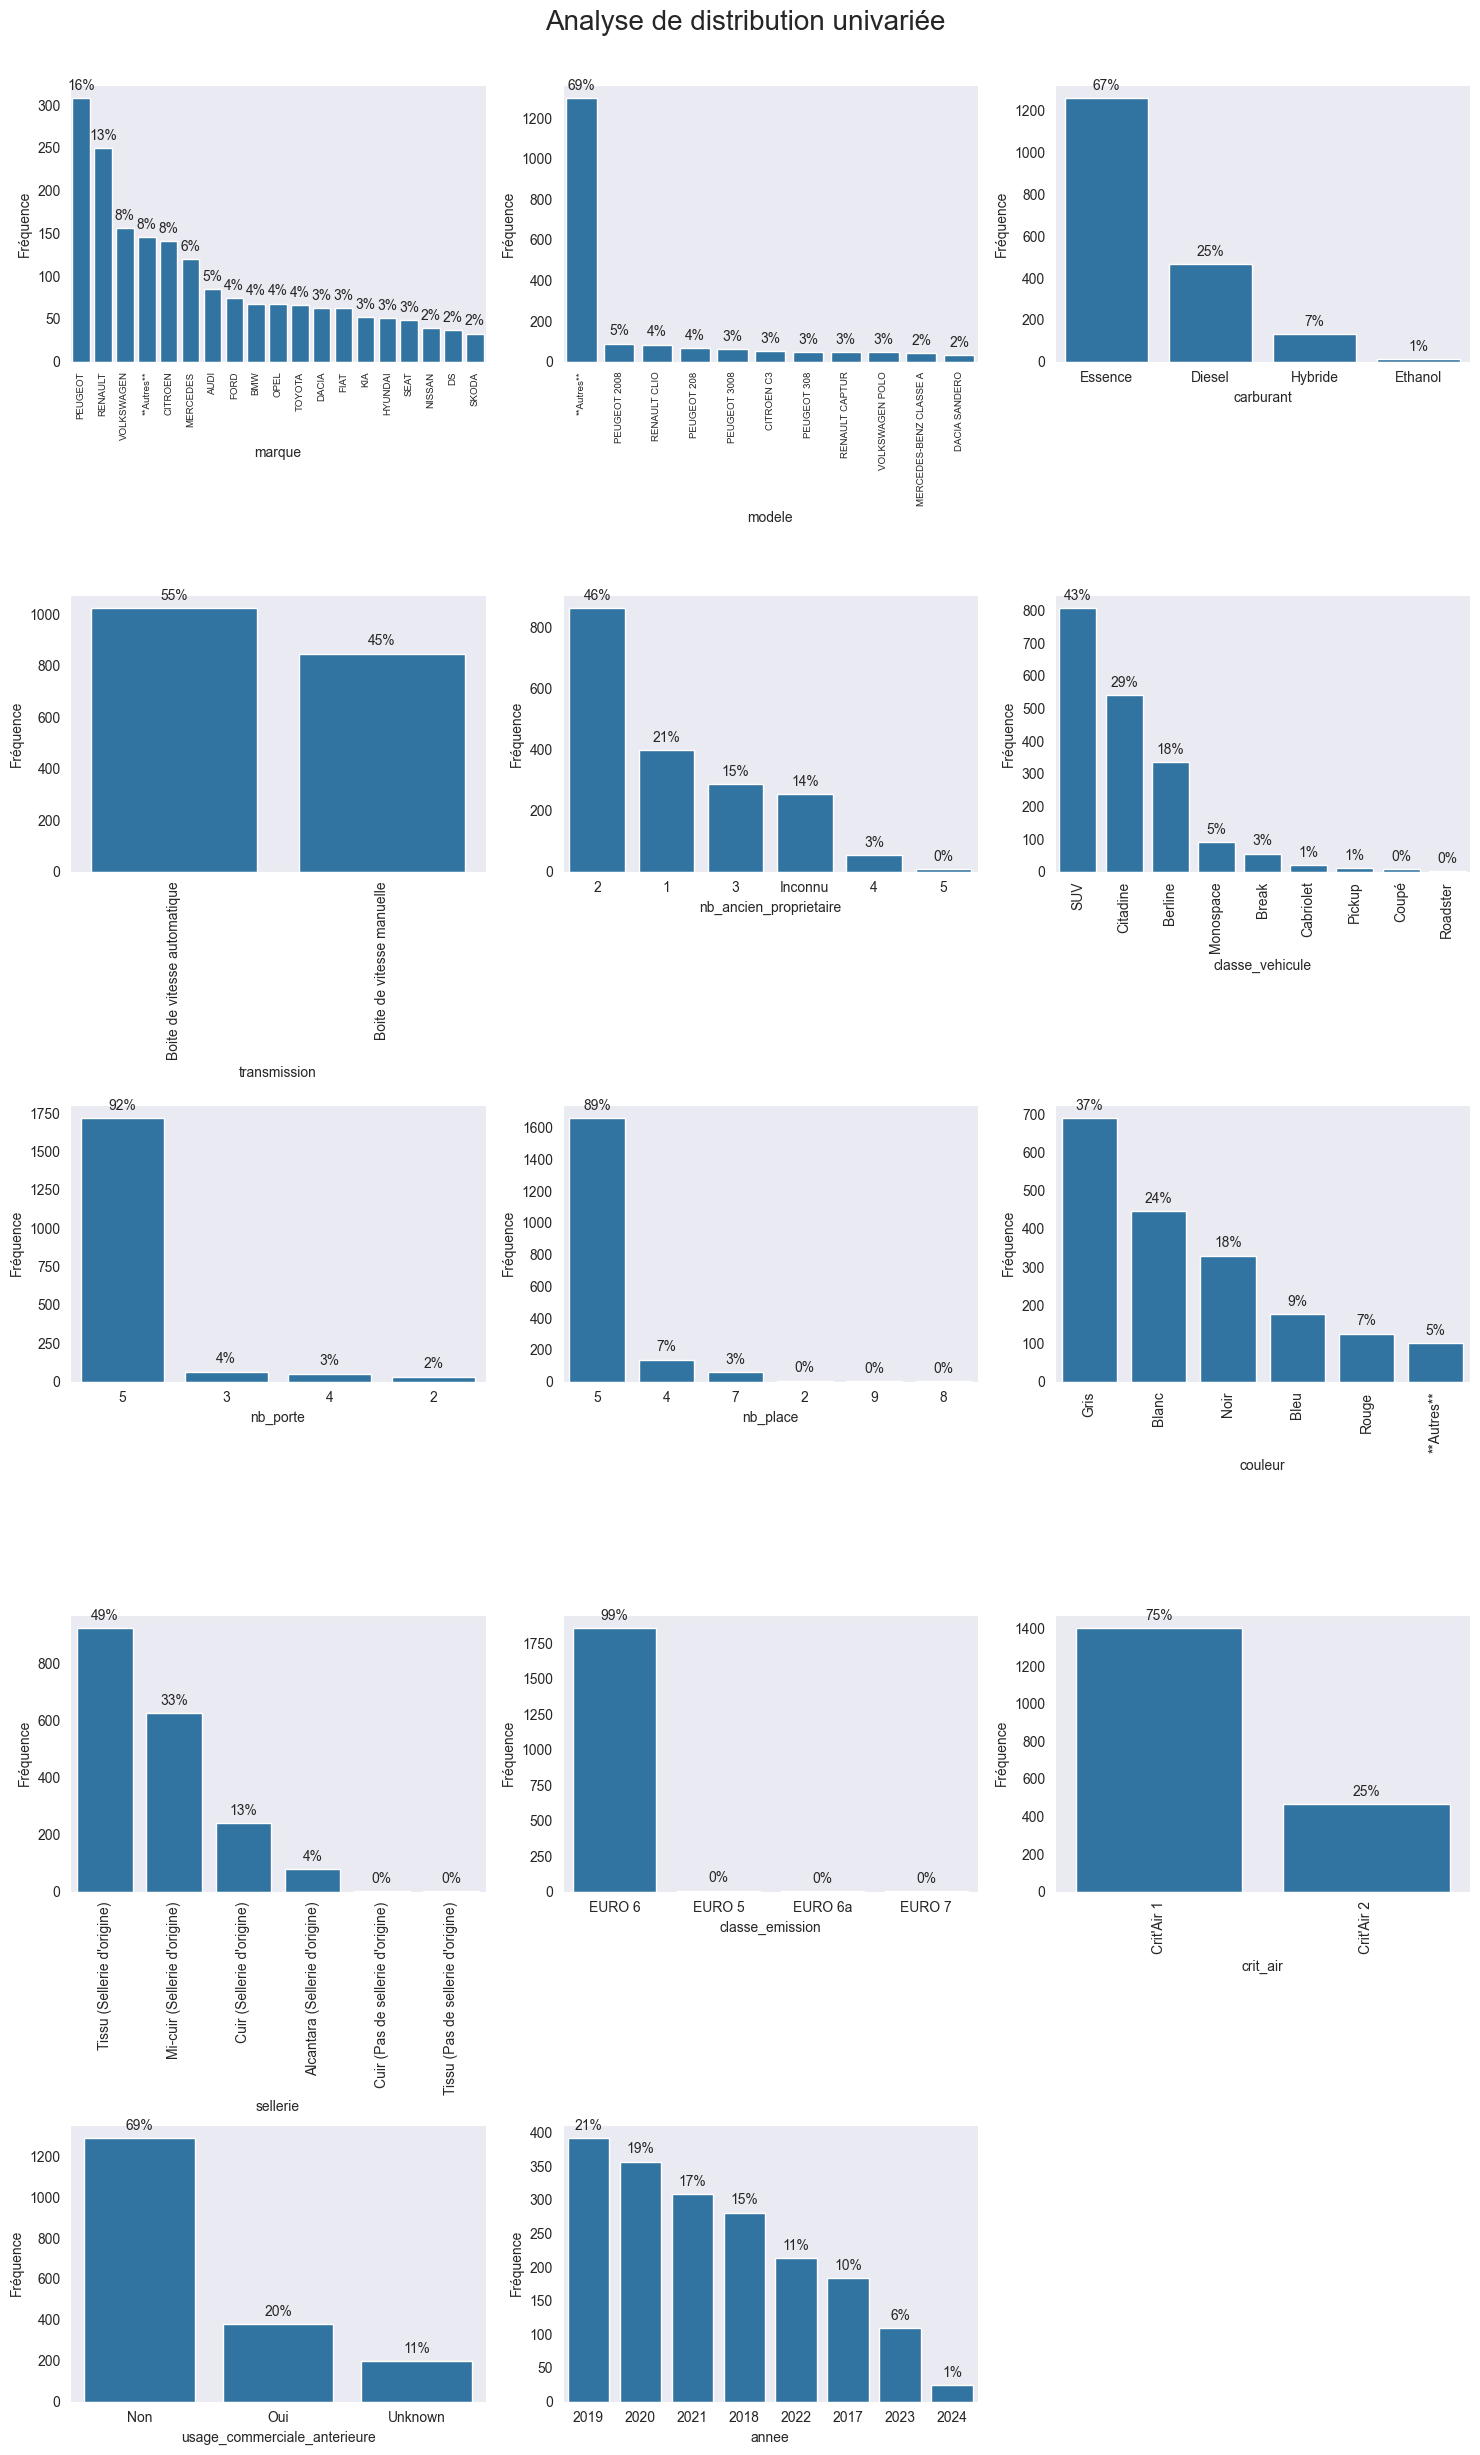

In [46]:
univariate_analysis(X_train, list_columns=categorical_variables, dtype="cat")

<u><b> Conclusion </b></u>:  
N.B: "Autres" = regroupement des modalités qui ont moins de 30 observations, quand il y a plus de 10 catégories
- Marque: Il y a 34 marques différentes dans le dataset. La majorité contient des marques françaises: Peugeot, Renault  
- Modèle: 221 modèles différents toutes marques comprises. Pas forcément un certain modèle qui domine la répartition
- Carburant:  Il y a 4 types de carburant recensés dans le dataset. La grande majorité est "Essence" avec 67% des obs, suivie par "Diesel" (25%). Hybride et Ethanol représentent peu. Pas Electrique dans le dataset.  
- Boite de vitesse: assez équilibré entre Automatique et Manuelle, avec des fréquences relativement plus hautes en boite Automatique  
- Nombre d'ancien propriétaire: 1 ou 2 anciens propriétaies en général  
- Classe véhicule: la majorité est SUV, Citadine, Berline  
- Nombre de porte & nombre de place: presque à 5 portes & 5 places  => assez traditionnel  
- Couleur: Gris, Blanc et Noir sont majoritaires
- Sellerie: Tissu ou Mi-cuir en général
- Classe d'émisison: presque la totalité est EURO-6
- Critair: la grande majorité est en Critair 1, le reste en Critair 2  => Voitures relativement au norme  
- Usage commerciale antérieure: Non dans 70% des cas
- Année de mise en circulation: la majorité est entre 2018 et 2021, très peu de fréquence sur les années récentes (2023, 2024)

#### b. Variables continues

In [47]:
# Liste des variables continues, y compris la variable cible
continuous_variables = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Supprimer des variables qui ne sont pas pertinentes pour l'analyse univariée
to_drop = ['id_annonce']
continuous_variables = [col for col in continuous_variables if col not in to_drop]

print(f"Liste des variables continues: {continuous_variables}")

Liste des variables continues: ['prix', 'kilometrage', 'puissance', 'emission_CO2', 'age_days', 'age_years', 'age_months', 'km_per_year', 'km_per_month', 'prix_neuf']


               count          mean           std     min           25%  \
prix          1869.0  17624.403424   6747.831671  6890.0       12490.0   
kilometrage   1869.0  57883.333333    25355.3691   527.0       38176.0   
puissance     1869.0    127.991439      38.98719    65.0         100.0   
emission_CO2  1869.0    121.849412     23.736354    23.0         110.0   
age_days      1869.0   1810.543071    625.115296   146.0        1395.0   
age_years     1869.0      4.959551      1.712334     0.4           3.8   
age_months    1869.0     60.351418     20.836722     4.9          46.5   
km_per_year   1869.0  12173.527715   5317.570799   251.0        8613.6   
km_per_month  1869.0    1000.46549    437.211894    20.6         709.8   
prix_neuf     1869.0  30654.701721  10934.915065  9990.0  22051.764706   

                  50%      75%      max  
prix          16390.0  21190.0  45590.0  
kilometrage   59649.0  79392.0  99987.0  
puissance       125.0    150.0    340.0  
emission_CO2    1

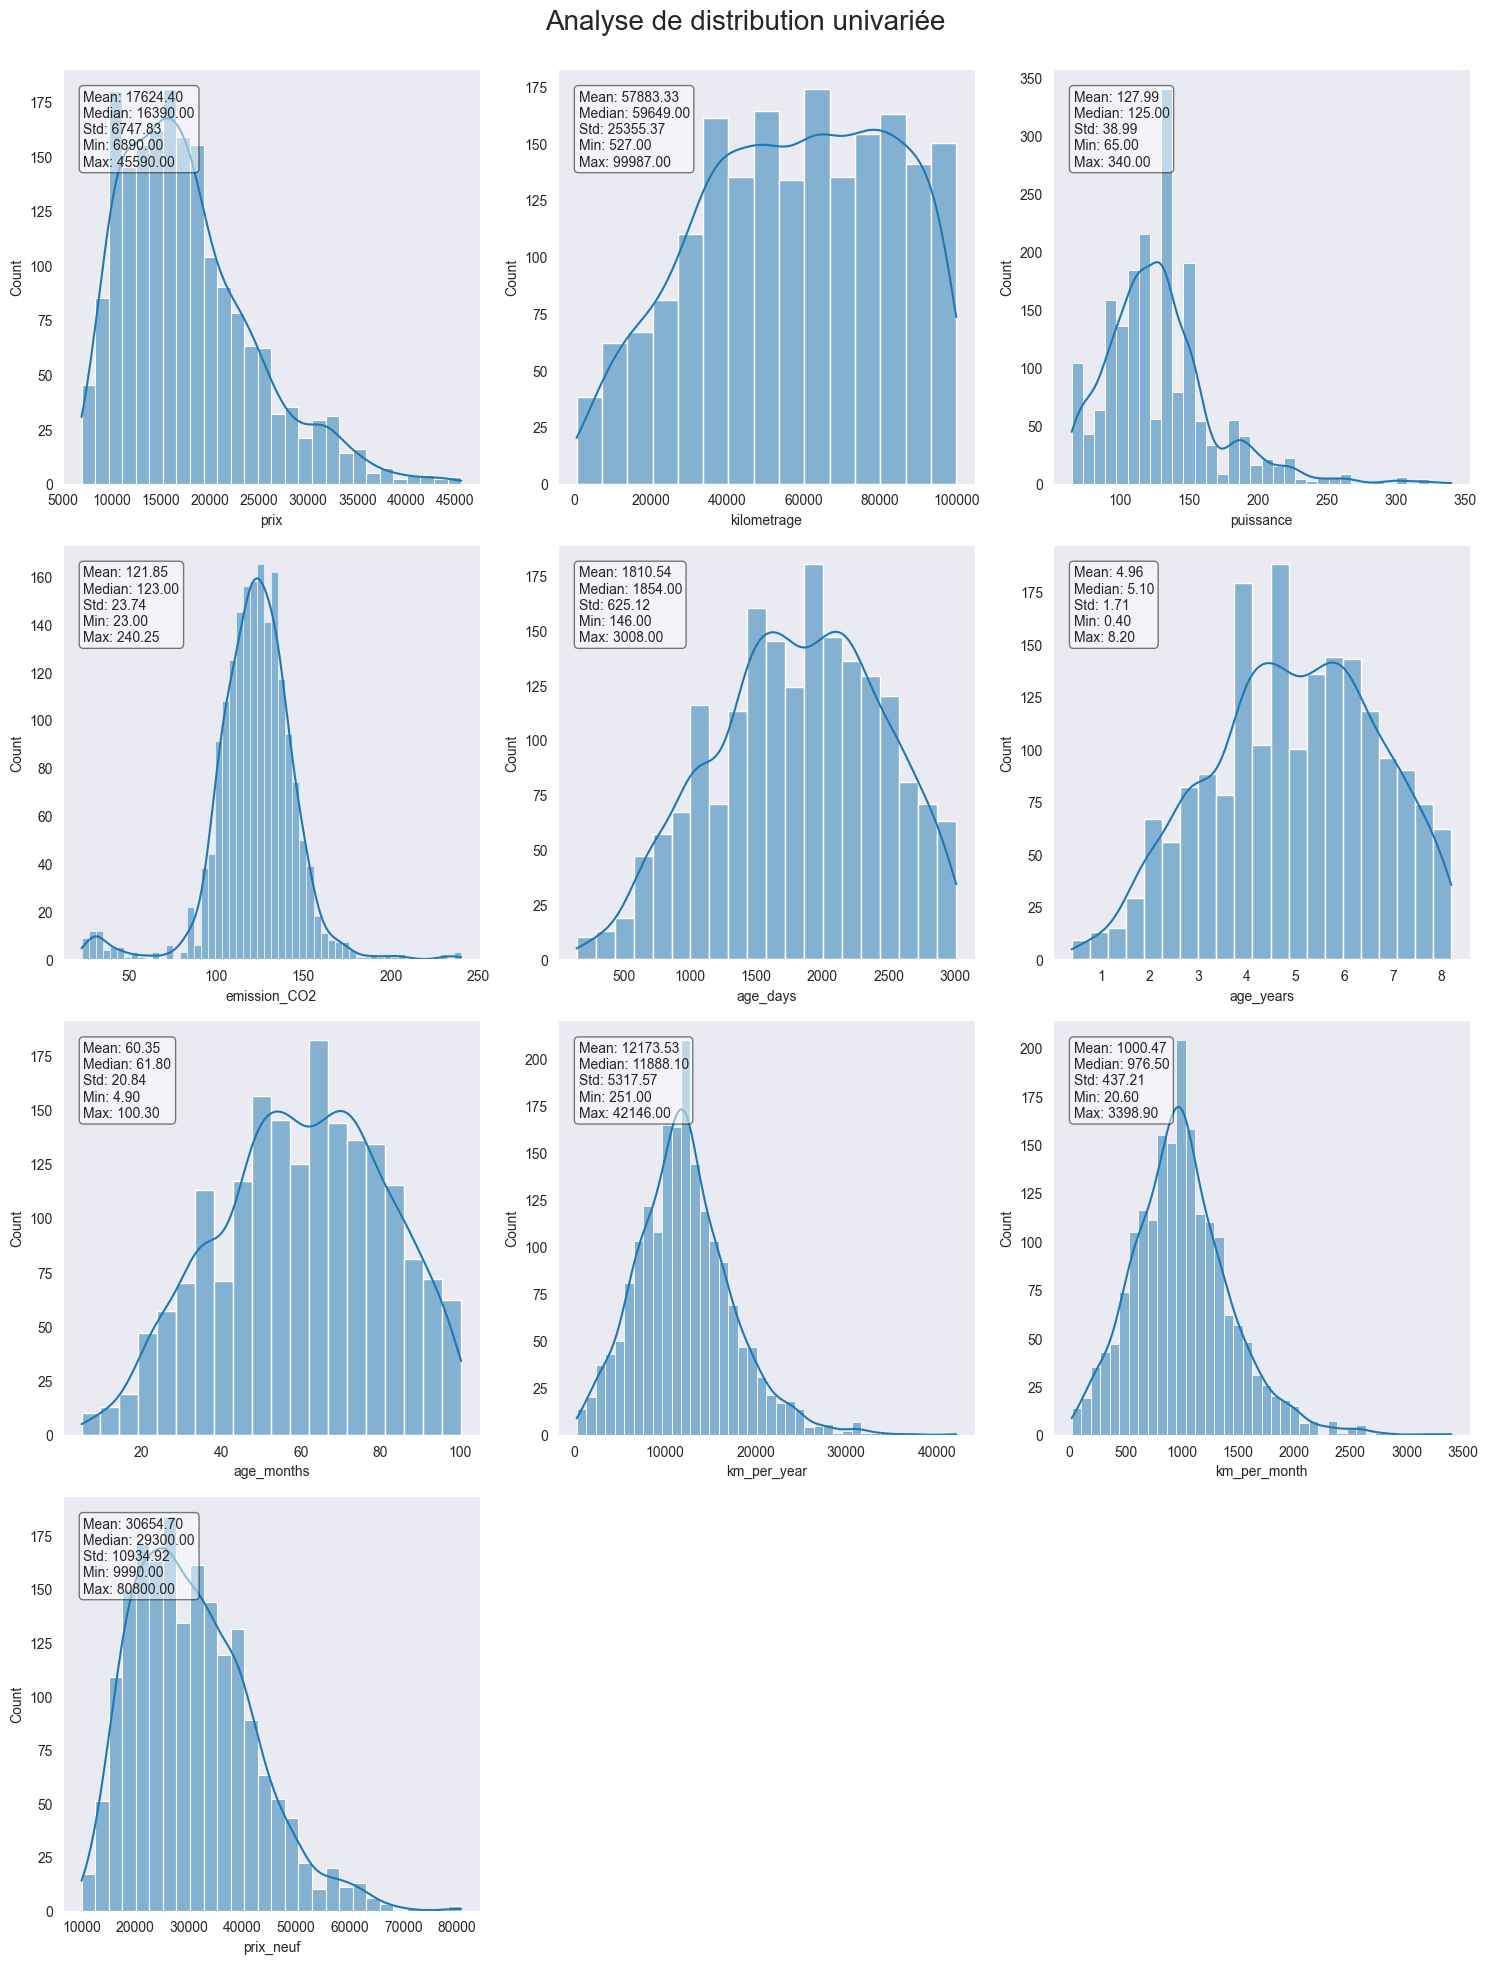

In [48]:
univariate_analysis(X_train, list_columns=continuous_variables, dtype="num")

La distribution de prix d'occasion est relativement asymétrique à droite, avec une moyenne autour de 17K€  
Par construction lors de la collecte des données, le kilométrage est borné à 100K km. Année de mise en circulation est floorée à 2017   
Le ratio VR moyen est aux alentours de 58% et celui-ci est proche de la médiane

### 2. Target vs variables catégorielles

Statistiques de Target value pour marque :
            count      mean       std       min       25%       50%       75%  \
marque                                                                          
DACIA        63.0  0.825534  0.091007  0.651253  0.779708  0.816336  0.895923   
ABARTH        7.0  0.744125  0.051716  0.670633  0.708241  0.772898  0.782416   
SUZUKI       21.0  0.723932  0.077330  0.595601  0.668516  0.740342  0.771066   
SMART         3.0  0.723343  0.038368  0.697778  0.701284  0.704790  0.736126   
MG            1.0  0.714150       NaN  0.714150  0.714150  0.714150  0.714150   
CUPRA         3.0  0.679574  0.070042  0.613372  0.642906  0.672439  0.712674   
TOYOTA       66.0  0.667187  0.090676  0.495565  0.608382  0.660723  0.701915   
VOLKSWAGEN  156.0  0.651343  0.090466  0.436537  0.588590  0.649292  0.724359   
SKODA        33.0  0.643611  0.078796  0.515009  0.577011  0.624777  0.710687   
SEAT         49.0  0.639152  0.070557  0.522407  0.587657  0.62921

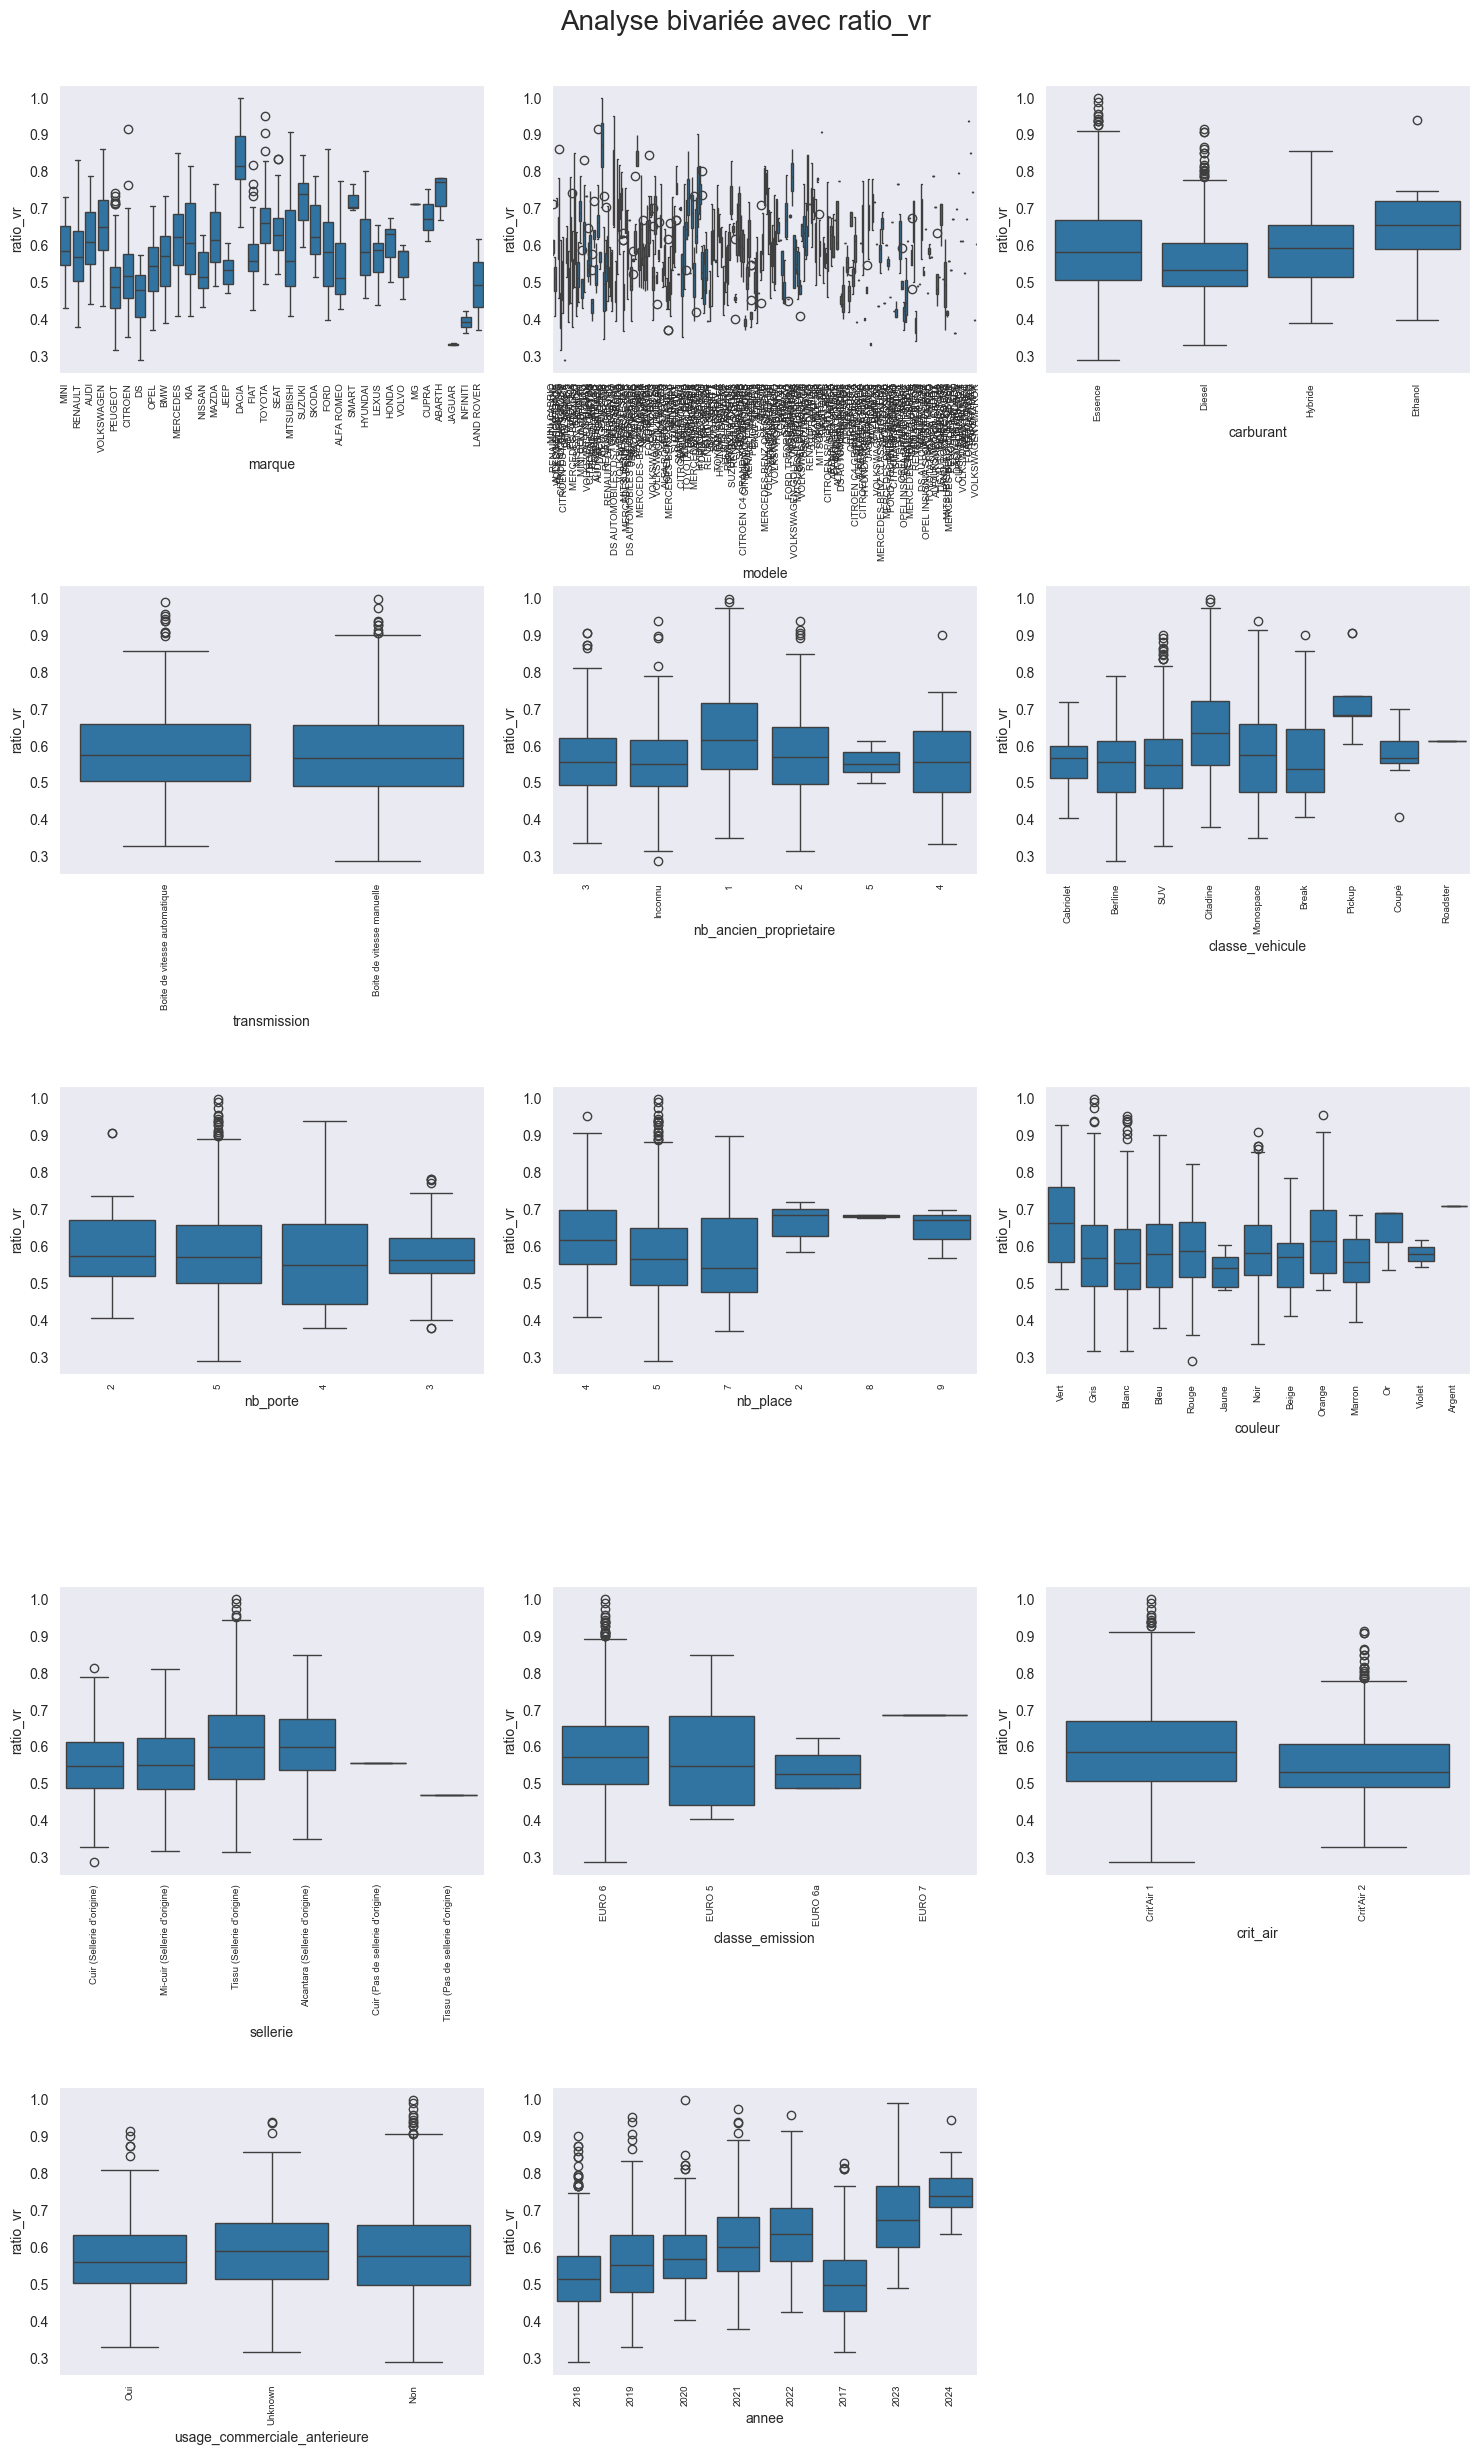

In [49]:
# Rassembler X_train et y_train pour l'analyse bivariée
X_y_train = pd.concat([X_train, y_train], axis=1) 
bivariate_analysis(X_y_train, list_columns=categorical_variables, dtype="cat", target_column=target_variable)

Les marques et modèles sont nombreux => Besoin potentiel de les regrouper ?  
Le taux de VR est moyennement plus élevé sur les voitures d'essence que diesel  
Il n'y a pas forcément d'écart significatif de ratio VR moyen entre les voitures de boite auto et de boite manuelle dans cet échantillon  
Les voitures qui ont 1 ancien propriétaire uniquement se vendent généralement plus cher  

                             count unique                           top  freq
marque                        1869     34                       PEUGEOT   308
modele                        1869    217                  PEUGEOT 2008    89
carburant                     1869      4                       Essence  1259
transmission                  1869      2  Boite de vitesse automatique  1023
nb_ancien_proprietaire        1869      6                             2   865
classe_vehicule               1869      9                           SUV   807
nb_porte                      1869      4                             5  1717
nb_place                      1869      6                             5  1660
couleur                       1869     13                          Gris   690
sellerie                      1869      6    Tissu (Sellerie d'origine)   923
classe_emission               1869      4                        EURO 6  1858
crit_air                      1869      2                    Cri

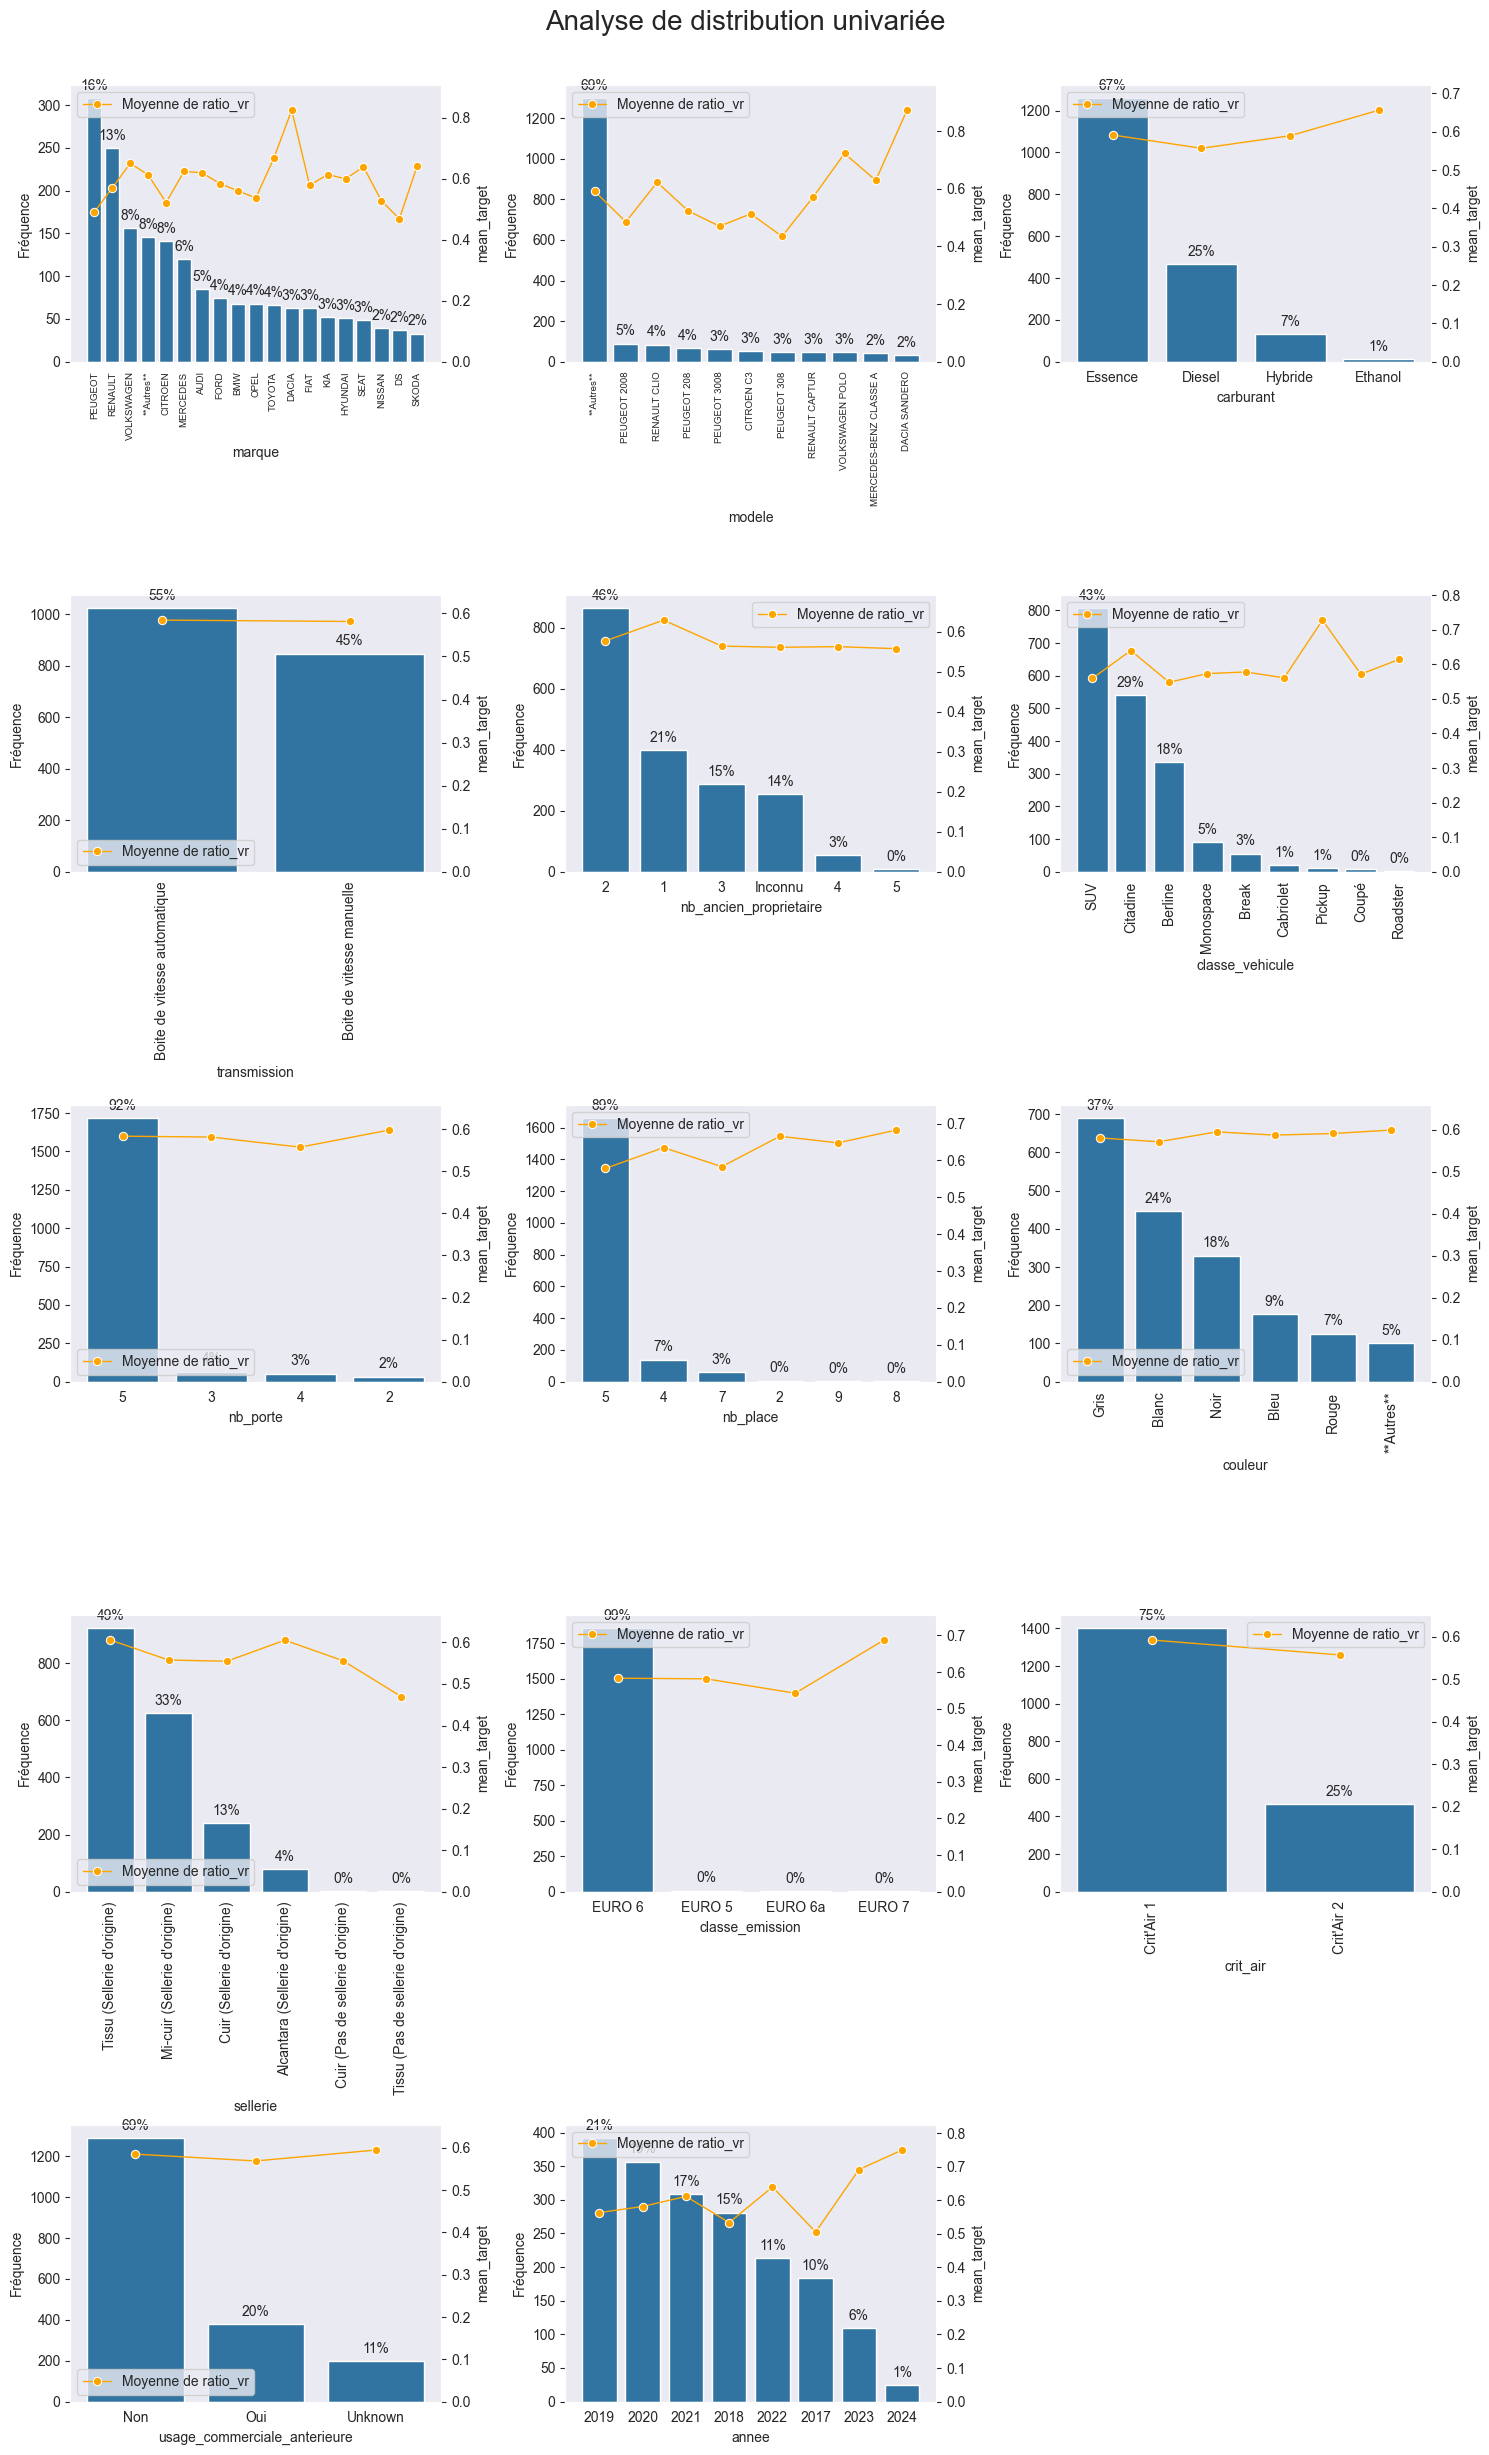

In [50]:
univariate_analysis(X_y_train, list_columns=categorical_variables, dtype="cat", target_column=target_variable)

In [51]:
# Regrouper les types de sellerie, ne prendre que la matière = élément avant la parenthèse
X_train['sellerie'] = X_train['sellerie'].str.split('(').str[0].str.strip()
print(f"Liste de sellerie après le regroupement: {sorted(set(X_train['sellerie']))}")

# Appliquer pour X_test
X_test['sellerie'] = X_test['sellerie'].str.split('(').str[0].str.strip()
print(f"Liste de sellerie après le regroupement pour l'échantillon de test: {sorted(set(X_test['sellerie']))}")

Liste de sellerie après le regroupement: ['Alcantara', 'Cuir', 'Mi-cuir', 'Tissu']
Liste de sellerie après le regroupement pour l'échantillon de test: ['Alcantara', 'Cuir', 'Mi-cuir', 'Tissu']


### 3. Target vs variables continues

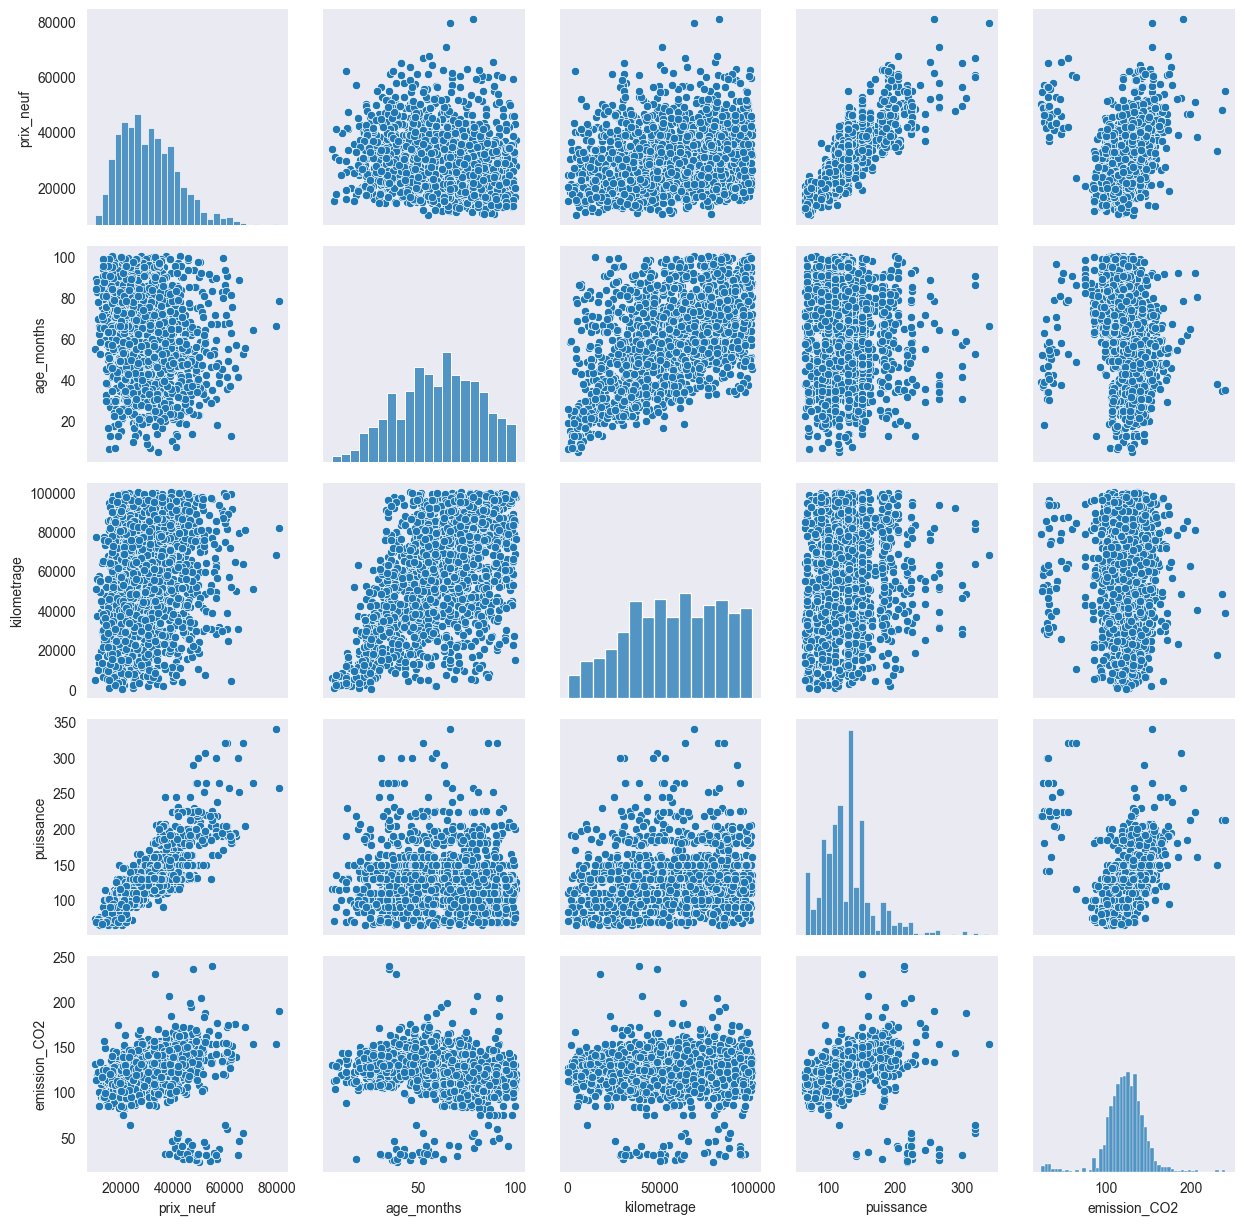

In [52]:
num_var_focus = ['prix_neuf', 'age_months', 'kilometrage', 'puissance', 'emission_CO2']
g = sns.PairGrid(X_y_train, vars=num_var_focus)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.fig_size = (8, 12)

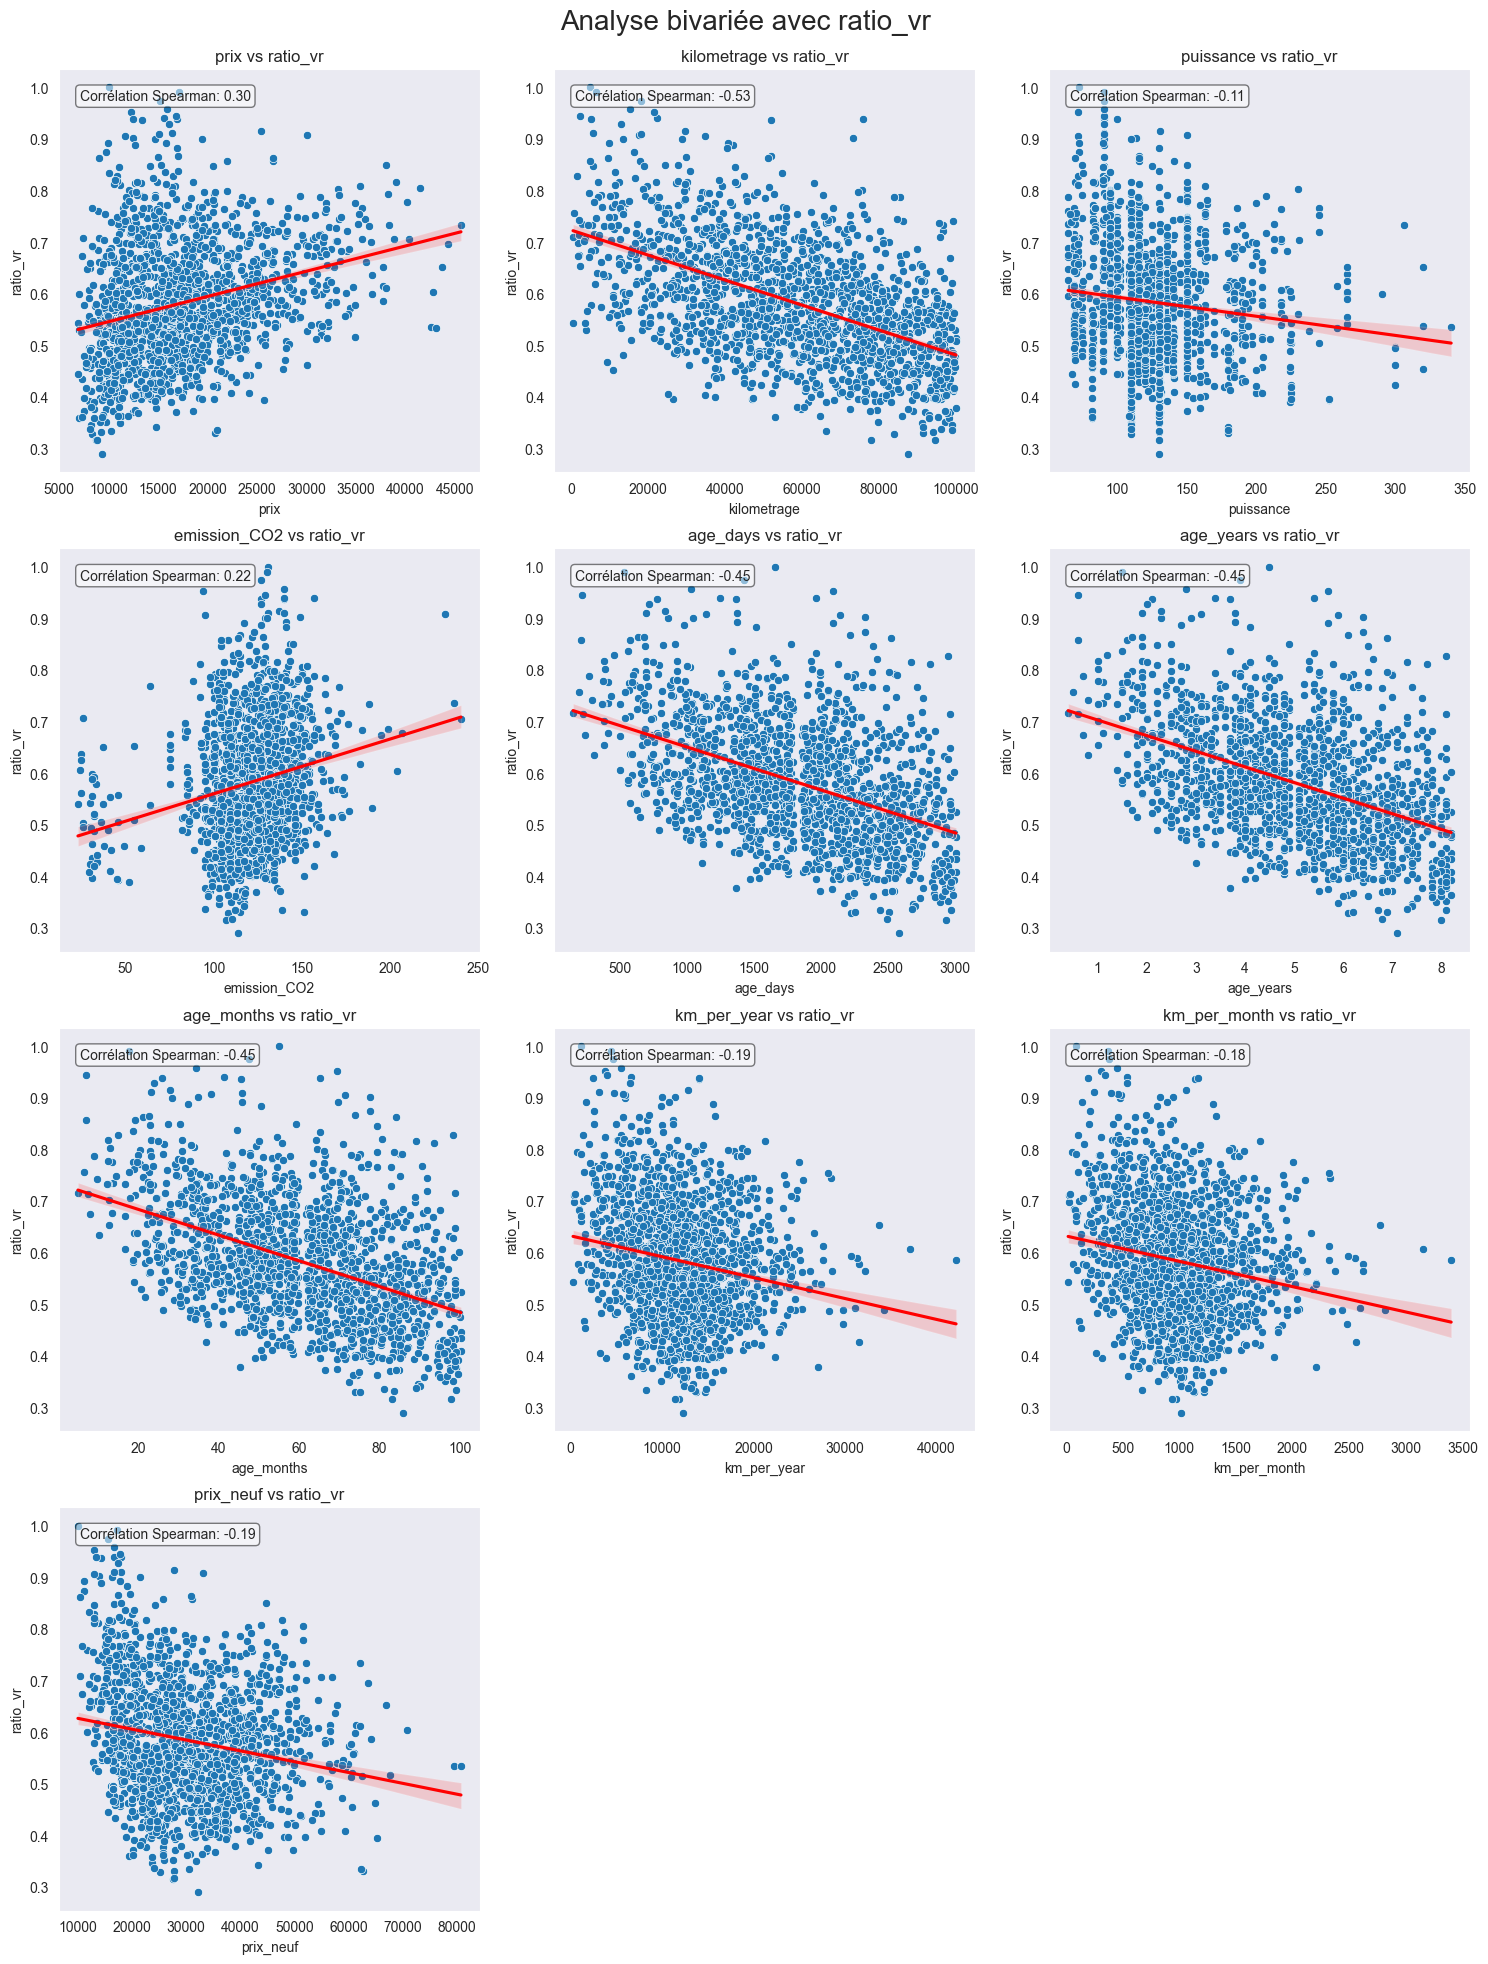

In [53]:
bivariate_analysis(X_y_train, list_columns=continuous_variables, dtype="num", target_column=target_variable)

### 4. Analyses multivariées

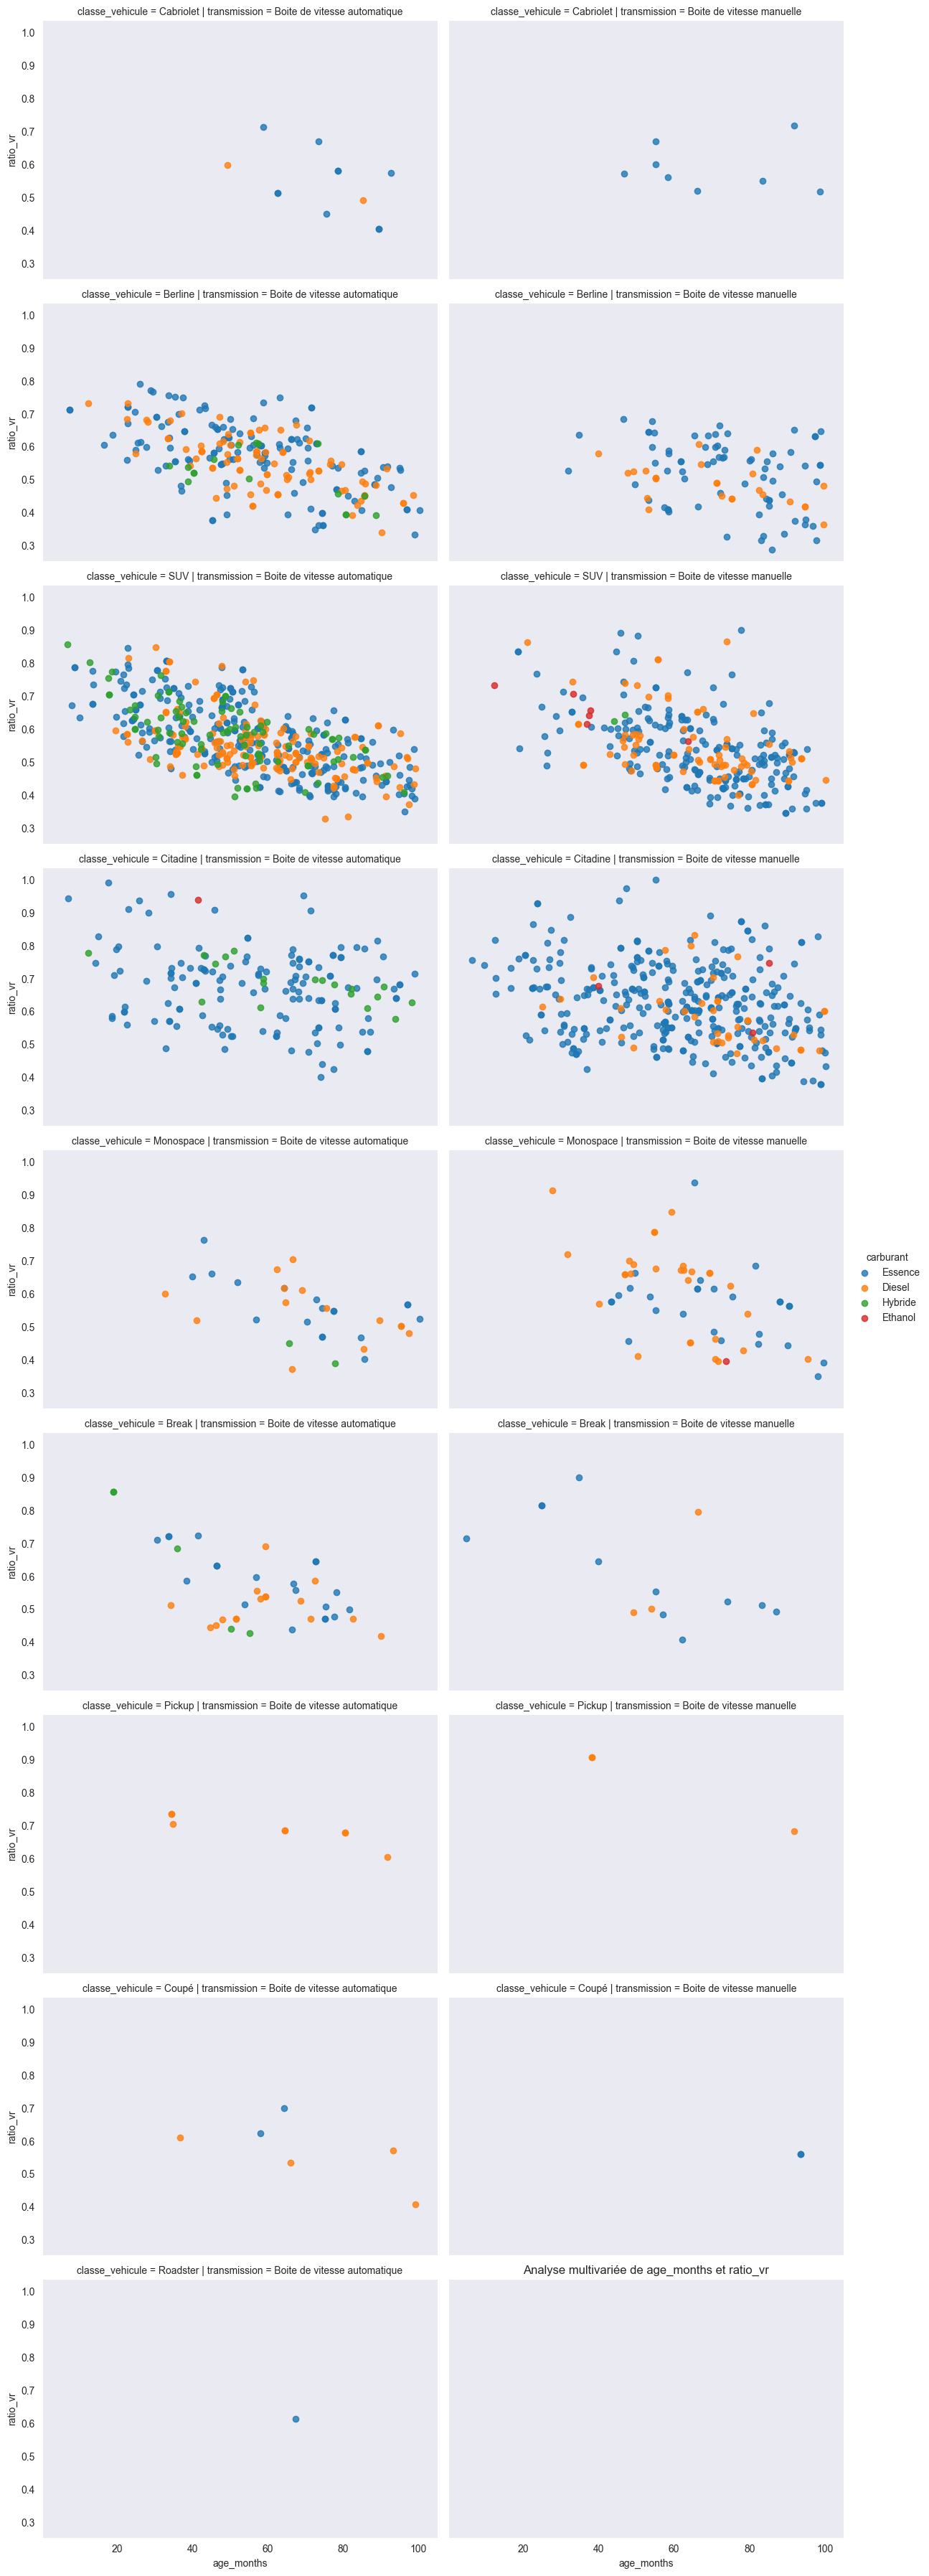

In [54]:
multivariate_analysis(X_y_train, x="age_months", y = target_variable, 
                      row="classe_vehicule", col="transmission", hue="carburant")

In [55]:
# Graphique de 3 dimensions avec Plotly: ratio_vr, age_months et kilometrage
scatter_3d(X_y_train, x="age_months", y="kilometrage", z=target_variable,
           x_title ="Age (mois)", y_title="Kilometrage (km)", z_title="Ratio VR", legend_title="Carburant", 
           color="carburant")

En général, Ratio VR en baisse avec l'augmentation de kilométrage parcouru et de l'âge du véhicule  
- Les véhicules Diesel sont plutôt anciens et de haut kilométrage.  
- A rappeler néanmoins la forte répartition des véhicules d'essence dans ce jeu de données

In [56]:
# Age et kilométrage moyen par type de carburant
agg_df_carb = X_y_train.groupby("carburant").agg(nb_annonce = ("id_annonce", "count"),
                                                       age_month_moyen = ("age_months", "mean"),
                                                       km_moyen = ("kilometrage", "mean"),
                                                       vr_moyen = ("ratio_vr", "mean")
                                                     )
agg_df_carb.insert(agg_df_carb.columns.get_loc("nb_annonce") + 1, 
                   "nb_annonce_pct", 
                   (agg_df_carb['nb_annonce']/agg_df_carb["nb_annonce"].sum()))
agg_df_carb.sort_values(by="nb_annonce_pct", ascending=False)

nb_annonce  nb_annonce_pct  age_month_moyen      km_moyen  vr_moyen
carburant                                                                     
Essence          1259        0.673622        60.686656  53792.506751  0.591535
Diesel            467        0.249866        61.859529  70119.811563  0.556830
Hybride           132        0.070626        52.738636  54367.378788  0.589636
Ethanol            11        0.005886        49.309091  48794.363636  0.656317

In [57]:
# Graphique de 3 dimensions avec Plotly: ratio_vr, age_months et prix_neuf
scatter_3d(X_y_train, x="age_months", y="prix_neuf", z=target_variable,
           x_title ="Age (mois)", y_title="Prix neuf", z_title="Ratio VR", legend_title="Carburant", 
           color="carburant")

In [58]:
# Graphique de 3 dimensions avec Plotly: ratio_vr, kilometrage et prix_neuf
scatter_3d(X_y_train, x="kilometrage", y="prix_neuf", z=target_variable,
           x_title ="Kilometrage (km)", y_title="Prix neuf", z_title="Ratio VR", legend_title="Carburant", 
           color="carburant")

## V. Categorical Embedding

In [59]:
# Nombre d'année group by modèle
X_train["modele"].value_counts()

modele
PEUGEOT 2008         89
RENAULT CLIO         84
PEUGEOT 208          68
PEUGEOT 3008         63
CITROEN C3           51
                     ..
DACIA DOKKER          1
FORD TOURNEO          1
ABARTH 595            1
FORD C-MAX            1
VOLKSWAGEN AMAROK     1
Name: count, Length: 217, dtype: int64

In [60]:
X_train["marque"].value_counts()

marque
PEUGEOT       308
RENAULT       250
VOLKSWAGEN    156
CITROEN       141
MERCEDES      120
AUDI           85
FORD           74
BMW            68
OPEL           68
TOYOTA         66
DACIA          63
FIAT           63
KIA            52
HYUNDAI        51
SEAT           49
NISSAN         39
DS             37
SKODA          33
MINI           28
MAZDA          21
SUZUKI         21
JEEP           14
MITSUBISHI     11
HONDA          10
ALFA ROMEO      9
LEXUS           7
ABARTH          7
VOLVO           5
SMART           3
CUPRA           3
INFINITI        2
JAGUAR          2
LAND ROVER      2
MG              1
Name: count, dtype: int64

Il serait intéressant de regrouper les modèles homogènes et pareillement pour les marques:  
- Réduire la dimension: on a 217 modèles différents dans le dataset => Beaucoup de modalités en one hot encoding alors que les données ne sont pas forcément représentatives sur qq uns. En plus, one-hot encoding ne permet pas de voir la similarité entre les différents modèles  
- Gérer les nouveaux modèles de voiture qui ne sont pas encore dans le dataset actuel

In [69]:
embed_features = ['marque', 'modele']
categorical_features = ['carburant', 'transmission', 'classe_vehicule', 'couleur']
numerical_features = ['kilometrage', 'puissance', 'emission_CO2', 'age_months', 'prix_neuf']

embedding_dims = {'marque': 2, 'modele': 2}

# Create model instance
model_handler = CategoricalEmbedding(
        df = X_y_train,
        embed_features=embed_features,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
        embedding_dims=embedding_dims,
        target_column=target_variable,
        hidden_layers = [128, 64, 32],
        dropout_rates= [0, 0, 0]
    )
# Prepare data for training
X_train_array, y_train_array = model_handler.prepare_data()

['ABARTH' 'ALFA ROMEO' 'AUDI' 'BMW' 'CITROEN' 'CUPRA' 'DACIA' 'DS' 'FIAT'
 'FORD' 'HONDA' 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA' 'LAND ROVER'
 'LEXUS' 'MAZDA' 'MERCEDES' 'MG' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL'
 'PEUGEOT' 'RENAULT' 'SEAT' 'SKODA' 'SMART' 'SUZUKI' 'TOYOTA' 'VOLKSWAGEN'
 'VOLVO']
['ABARTH 124 SPIDER' 'ABARTH 500' 'ABARTH 595' 'ABARTH 595C'
 'ALFA ROMEO GIULIA' 'ALFA ROMEO GIULIETTA' 'ALFA ROMEO STELVIO'
 'ALFA ROMEO TONALE' 'AUDI A1' 'AUDI A3' 'AUDI A3 LIMOUSINE' 'AUDI A4'
 'AUDI A5 SPORTBACK' 'AUDI A6' 'AUDI Q2' 'AUDI Q3' 'AUDI Q3 SPORTBACK'
 'AUDI Q5' 'AUDI TT' 'BMW SÉRIE 1' 'BMW SÉRIE 2' 'BMW SÉRIE 3'
 'BMW SÉRIE 4' 'BMW SÉRIE 5' 'BMW X1' 'BMW X2' 'BMW X3' 'BMW X4' 'BMW Z4'
 'CITROEN BERLINGO' 'CITROEN C1' 'CITROEN C3' 'CITROEN C3 AIRCROSS'
 'CITROEN C4' 'CITROEN C4 CACTUS' 'CITROEN C4 GRAND PICASSO'
 'CITROEN C4 GRAND SPACETOURER' 'CITROEN C4 PICASSO'
 'CITROEN C4 SPACETOURER' 'CITROEN C5 AIRCROSS' 'CITROEN C5 X'
 'CITROEN DS3' 'CITROEN DS3 CABRIO' 'CITROEN DS4' 

In [70]:
model = model_handler.create_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics =['mae'])

c:\Users\Hong-CuongLE\OneDrive - NEXIALOG\Documents\Valeur-Residuelle\.venv\lib\site-packages\keras\src\models\functional.py:107: UserWarning:

When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'marque' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=_input_marque> which has name '_input_marque'. Change the tensor name to 'marque' (via `Input(..., name='marque')`)

c:\Users\Hong-CuongLE\OneDrive - NEXIALOG\Documents\Valeur-Residuelle\.venv\lib\site-packages\keras\src\models\functional.py:107: UserWarning:

When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'modele' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=_input_modele> which has name '_input_modele'. Change the tensor name to 'modele' (via `Input(..., name='modele')`)

c:\Users\Hong-CuongLE\OneDrive

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ _input_marque       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ _input_modele       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ marque_embedding    │ (None, 1, 2)      │         68 │ _input_marque[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modele_embedding    │ (None, 1, 2)      │        434 │ _input_modele[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2)         │          0 │ marque_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2)         │          0 │ modele_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ _input_carburant    │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ _input_transmission │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ _input_classe_vehi… │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ _input_couleur      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_num_features  │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 37)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ _input_carburant… │
│                     │                   │            │ _input_transmiss… │
│                     │                   │            │ _input_classe_ve… │
│                     │                   │            │ _input_couleur[0… │
│                     │                   │            │ input_num_featur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      4,864 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,735 (61.46 KB)

 Trainable params: 15,735 (61.46 KB)

 Non-trainable params: 0 (0.00 B)

None


In [71]:
# Train the model
history = model.fit(X_train_array, y_train_array,  
                    epochs=10, batch_size=32)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0342 - mae: 0.1378
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mae: 0.0671
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 - mae: 0.0509
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - mae: 0.0391  
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mae: 0.0342
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0322  
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - mae: 0.0305
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mae: 0.0288
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0265
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0263    


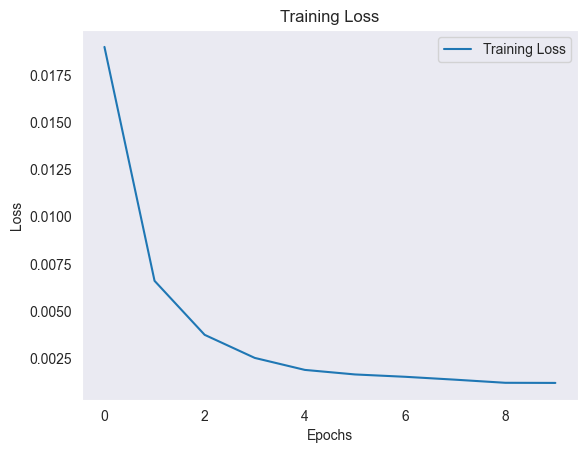

In [72]:
plt.plot(history.history['loss'], label ='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

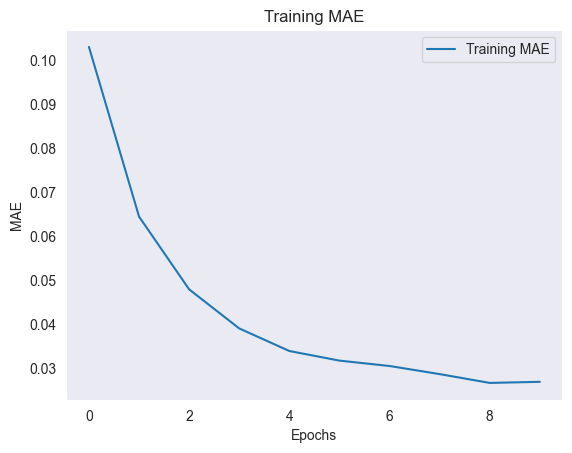

In [73]:
# Summary history for MAE
plt.plot(history.history['mae'], label ='Training MAE')
plt.title('Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Visualizing embeddings for marque:
            marque_0  marque_1
ABARTH     -0.011393  0.021148
ALFA ROMEO  0.014206  0.009857
AUDI       -0.046262  0.139051
BMW        -0.035921  0.075252
CITROEN     0.024714 -0.115326
CUPRA      -0.037809  0.005264
DACIA      -0.094181  0.073941
DS          0.112174 -0.160581
FIAT        0.068429 -0.038254
FORD       -0.034817 -0.024620
HONDA       0.006998  0.066169
HYUNDAI     0.003809  0.027610
INFINITI    0.065392 -0.091258
JAGUAR      0.030663 -0.058329
JEEP        0.083593  0.019400
KIA         0.036164  0.070428
LAND ROVER -0.054839 -0.030702
LEXUS      -0.057806  0.093333
MAZDA      -0.044677  0.026541
MERCEDES   -0.122951  0.057359
MG          0.028753  0.008860
MINI       -0.034334  0.050944
MITSUBISHI  0.068861 -0.105584
NISSAN      0.056805 -0.013842
OPEL        0.025886 -0.120295
PEUGEOT     0.010804 -0.146350
RENAULT     0.066658  0.001082
SEAT       -0.014922  0.067154
SKODA      -0.000059  0.093640
SMART      -0.053225  0.073894
SUZ

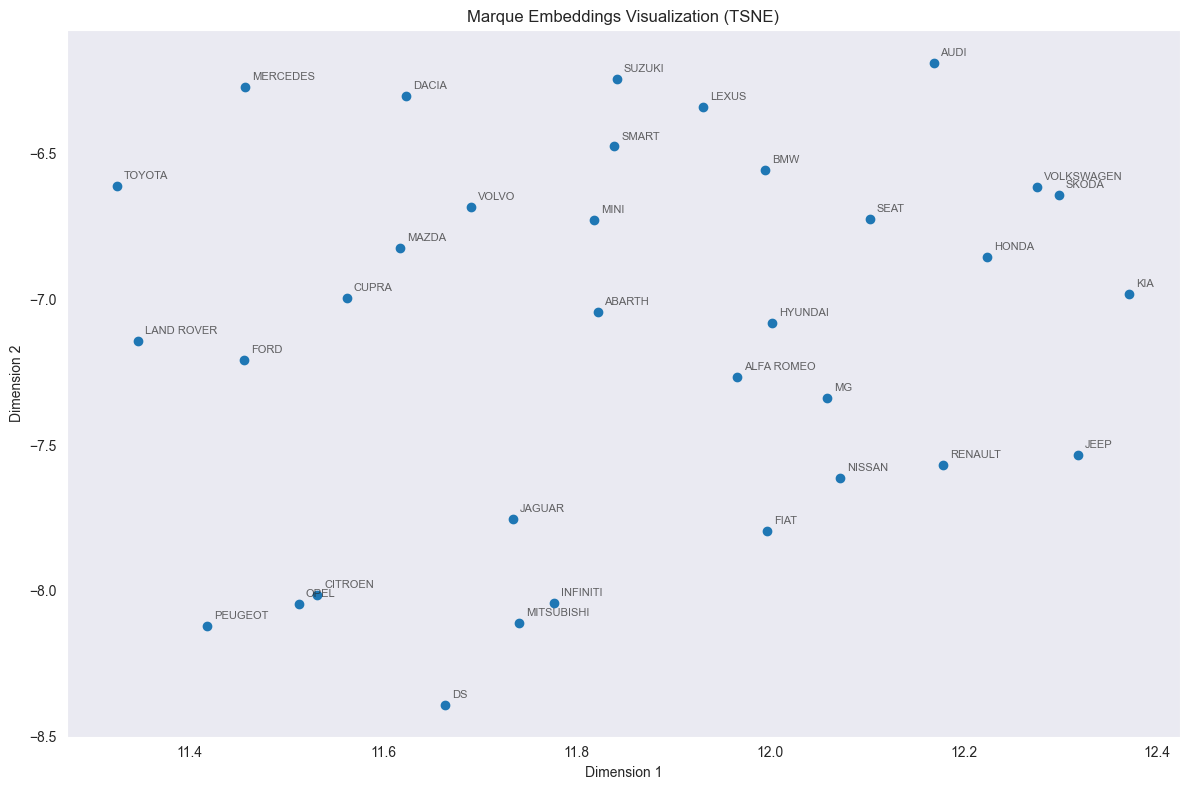

            marque_0  marque_1
ABARTH     -0.011393  0.021148
ALFA ROMEO  0.014206  0.009857
AUDI       -0.046262  0.139051
BMW        -0.035921  0.075252
CITROEN     0.024714 -0.115326
CUPRA      -0.037809  0.005264
DACIA      -0.094181  0.073941
DS          0.112174 -0.160581
FIAT        0.068429 -0.038254
FORD       -0.034817 -0.024620
HONDA       0.006998  0.066169
HYUNDAI     0.003809  0.027610
INFINITI    0.065392 -0.091258
JAGUAR      0.030663 -0.058329
JEEP        0.083593  0.019400
KIA         0.036164  0.070428
LAND ROVER -0.054839 -0.030702
LEXUS      -0.057806  0.093333
MAZDA      -0.044677  0.026541
MERCEDES   -0.122951  0.057359
MG          0.028753  0.008860
MINI       -0.034334  0.050944
MITSUBISHI  0.068861 -0.105584
NISSAN      0.056805 -0.013842
OPEL        0.025886 -0.120295
PEUGEOT     0.010804 -0.146350
RENAULT     0.066658  0.001082
SEAT       -0.014922  0.067154
SKODA      -0.000059  0.093640
SMART      -0.053225  0.073894
SUZUKI     -0.077295  0.096810
TOYOTA  

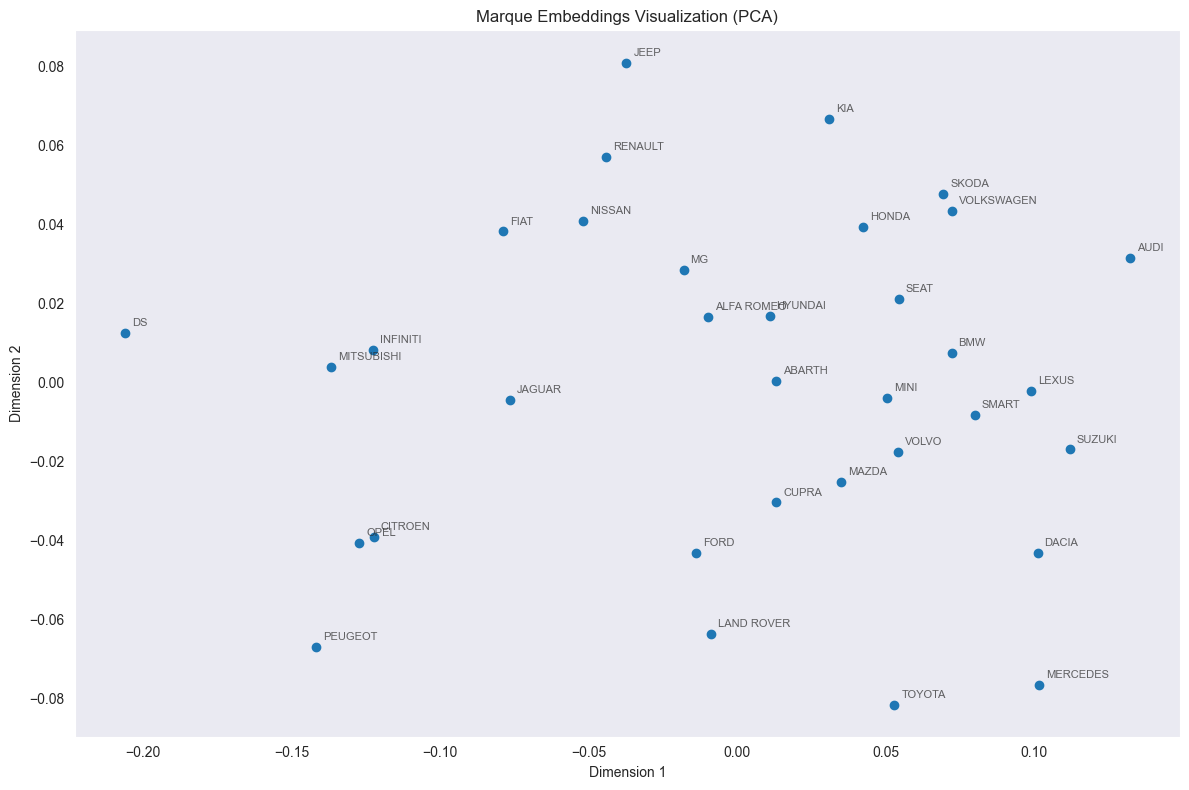


Visualizing embeddings for modele:
                   modele_0  modele_1
ABARTH 124 SPIDER  0.043937 -0.045653
ABARTH 500        -0.076751 -0.013094
ABARTH 595         0.083907 -0.021841
ABARTH 595C        0.022119 -0.004391
ALFA ROMEO GIULIA  0.068514 -0.068809
...                     ...       ...
VOLKSWAGEN TOURAN  0.049122 -0.034568
VOLKSWAGEN UP!    -0.079604  0.073148
VOLVO V40         -0.026719  0.035634
VOLVO XC40        -0.011007 -0.050036
VOLVO XC60         0.006716 -0.008816

[217 rows x 2 columns]


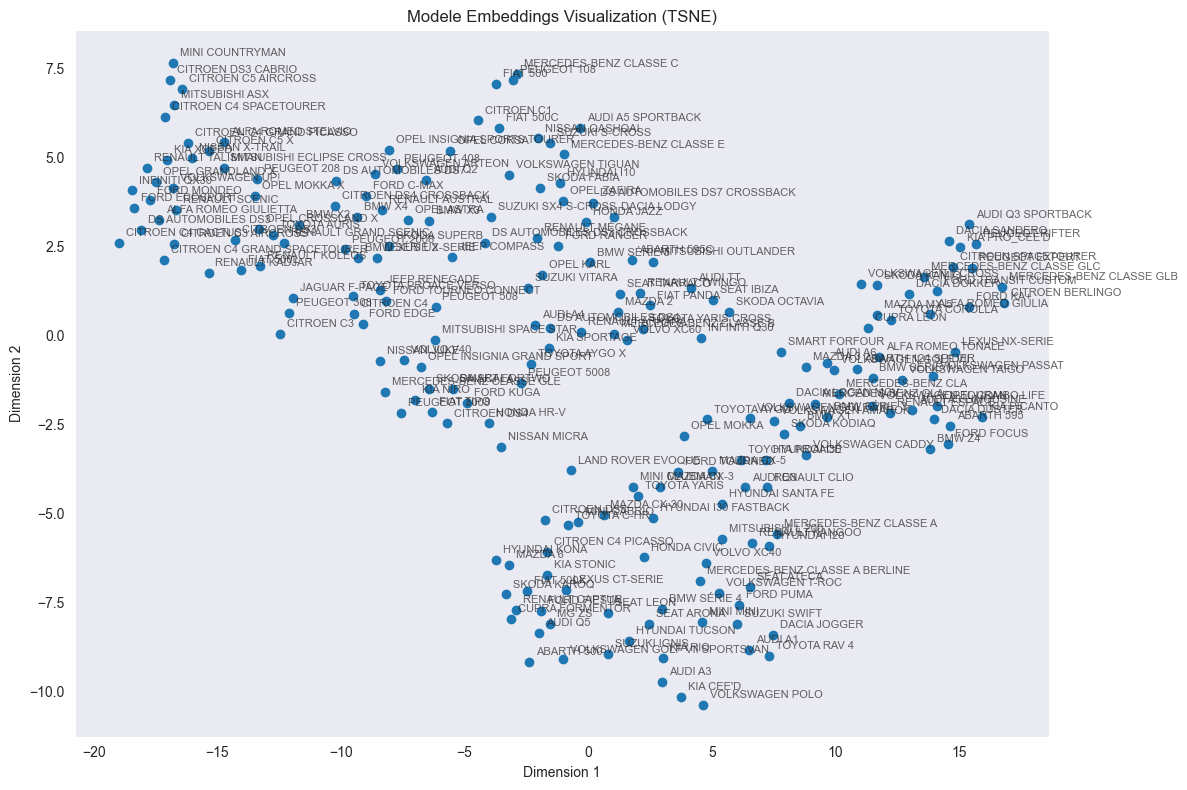

                   modele_0  modele_1
ABARTH 124 SPIDER  0.043937 -0.045653
ABARTH 500        -0.076751 -0.013094
ABARTH 595         0.083907 -0.021841
ABARTH 595C        0.022119 -0.004391
ALFA ROMEO GIULIA  0.068514 -0.068809
...                     ...       ...
VOLKSWAGEN TOURAN  0.049122 -0.034568
VOLKSWAGEN UP!    -0.079604  0.073148
VOLVO V40         -0.026719  0.035634
VOLVO XC40        -0.011007 -0.050036
VOLVO XC60         0.006716 -0.008816

[217 rows x 2 columns]


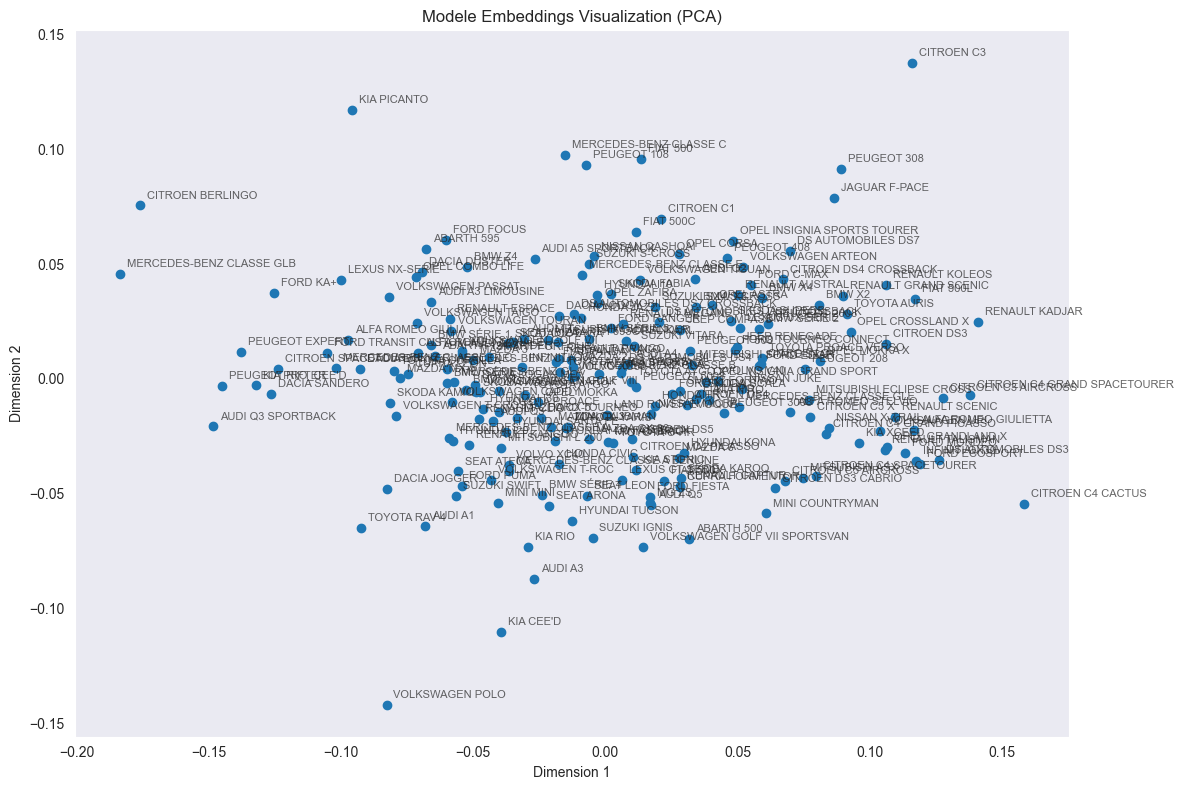

In [74]:
visualize_all_embeddings(model_handler, model)

## VI. Variables encoding and scaling pipelines

In [ ]:
# Nombre de modalités par variable catégorielle
{col : X_train[col].nunique() for col in X_train.select_dtypes(include="object").columns}

In [ ]:
X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Supprimer les colonnes non pertinentes pour l'analyse
# id_annonce: c'est un identifiant unique pour chaque annonce, donc pas pertinent pour l'analyse
# annee: c'est l'année de l'annonce, mais on a déjà l'âge de la voiture en mois, donc pas nécessaire
# On va donc supprimer ces deux colonnes des DataFrames d'entraînement et de test
X_train.drop(columns=['id_annonce', 'annee'], inplace=True)
X_test.drop(columns=['id_annonce', 'annee'], inplace=True)

In [ ]:
cat_to_transform = [cat for cat in categorical_variables if cat not in ['modele', 'marque', 'annee', 'nb_ancien_proprietaire']]
print(cat_to_transform)

In [ ]:
special_cat = {'nb_ancien_proprietaire': '1'}

In [ ]:
num_to_transform = [num for num in continuous_variables if num not in ['ratio_vr']]
print(num_to_transform)

In [ ]:
# Pipeline pour encoder les variables catégorielles
transform_pipeline = create_transformer_pipeline(categorical_features=cat_to_transform,
                                                 special_impute_cat_features=special_cat,
                                                 numerical_features=num_to_transform)
print(transform_pipeline)

In [ ]:
X_train_prepared = transform_pipeline.fit_transform(X_train)

In [ ]:
X_train_prepared

In [ ]:
# Display all transformers in the pipeline
for name, transformer, features in transform_pipeline.transformers_:
	print(f"Name: {name}, Transformer: {transformer}, Features: {features}")
	# Only access 'onehot' if it exists in the pipeline steps
	if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
		print(transformer.named_steps['onehot'])

In [ ]:
# Ajouter le nom des colonnes dans la data transformée
feature_names = []
for name, transformer, features in transform_pipeline.transformers_:
    if name == 'remainder':
        feature_names.extend(X_train.columns[features])
    if name == 'regular_cat':
        encoder_cat = transformer.named_steps['onehot']
        feature_names.extend(encoder_cat.get_feature_names_out(features))
    elif name in special_cat.keys():
        encoder_spe_cat = transformer.named_steps['onehot']
        feature_names.extend(encoder_spe_cat.get_feature_names_out(features))
    elif name == 'regular_num':
        feature_names.extend(features)

In [ ]:
feature_names

In [ ]:
X_train_transformed_df = pd.DataFrame(X_train_prepared, columns=feature_names) 

In [ ]:
X_train_transformed_df

In [ ]:
# Corrélation entre les variables numériques
X_y_train_transformed_df = pd.concat([X_train_transformed_df, y_train])

## VII. Training

In [ ]:
# Lancer une régression linéaire pour prédire le ratio VR
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)